**Trabajo entregado el 01-10-2024**

El objetivo del presente trabajo es estudiar diferentes datasets disponibles en el paquete torch_geometric de Python en búsqueda de ver cémo estos cumplen la **hipótesis de mundo pequeño (Small World)**, que consiste básicamente en decir que en los grafos que representan relaciones sociales o de comunicación, la distancia promedio entre dos nodos crece a una velocidad mucho menor (en la definición de métricas le daremos un significado numérico a esto) que el tamaño (cantidad de nodos) del grafo.

Afortunadamente, la librería antes mencionada nos proporciona una amplia variedad de grafos que podemos utilizar para estudiar esta hipótesis. 

\tableofcontents

# Definición de métricas <a id="definicion"></a>

Lo primero que debemos hacer para explorar la teoría de mundo pequeño es definir métricas me-di-bles que plasmen la idea.

Vamos a explorar 3 métricas para los diferentes grafos:

* Diámetro: La máxima distancia entre dos nodos.
* Distancia promedio: La distancia promedio entre todos los posibles pares de nodos.
* Coeficiente de agrupamiento: Es la cantidad de triángulos (un clique de 3 nodos) dividida la cantidad de conjuntos {a,b,c} donde (a,b) y (b,c) son aristas del grafo.

La hipótesis de mundo pequeño dice que, para un grafo social de $N$ nodos:
* Las dos primeras métricas deberían comportarse como $O(log(N))$
* La tercera métrica debe ser mayor o igual a $\frac{M}{\binom{N}{2}}$.

Otra forma de verlo es que estas 3 métricas se deben parecer a las de un grafo aleatorio de Erdos-Renyi con la misma cantidad de nodos y aristas, comportándose las 2 primeras como $O(log(N))$ y la tercera como $O(\frac{M}{\binom{N}{2}})$.

Utilizaremos la librería igraph por motivos de performance.


In [22]:
import networkx as nx
import igraph
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
import joblib as jb


def Informar(dataset, nombre):
    nxG = to_networkx(dataset, to_undirected=True)
    G = igraph.Graph.from_networkx(nxG)
    mensaje = f"El dataset {nombre} tiene {G.vcount()} nodos\n" 
    print(f"El dataset {nombre} tiene {G.vcount()} nodos ")
    diametro, distancia_promedio = 0,0
    if G.is_connected():
        print(f"\t Es conexo ")
        mensaje += "\t Es conexo\n"
    else:
        print(f"\t No es conexo, y respecto de la componente más grande:")
        mensaje += "\t No es conexo, y respecto de la componente más grande:\n"
        mayor_cc = max(G.components(), key=len)
        G = G.subgraph(mayor_cc)
    
    diametro = G.diameter()
    distancia_promedio = G.average_path_length()
    agrupamiento_global = igraph.mean(G.transitivity_undirected())
    print(f"\t Su diámetro es {diametro}")
    print(f"\t La distancia promedio entre nodos es {distancia_promedio}")
    print(f"\t Su coeficiente de agrupamiento es {agrupamiento_global}")
    mensaje += f"\t Su diámetro es {diametro}\n"
    mensaje += f"\t La distancia promedio entre nodos es {distancia_promedio}\n"
    mensaje += f"\t Su coeficiente de agrupamiento es {agrupamiento_global}\n"
    return (G.vcount(), G.ecount(), diametro, distancia_promedio, agrupamiento_global,G, mensaje)
      

In [23]:
# Guardamos los resultados para no calcularlos varias veces
# también para eso los almacenamos en un archivo
try:
    resultados = jb.load("variables/resultados.jb")
except:
    resultados = dict()

# Estudio de distintos datasets

## Karate Club

Este es un dataset bastante pequeño, utilizado como primer ejemplo en muchos trabajos sobre grafos, especialmente en el área de aprendizaje automático.

Los enlaces refieren a los miembros de un club de karate que interactúan (son amigos) fuera del club.

In [24]:
from torch_geometric.datasets import KarateClub

if "Karate Club" not in resultados:
    resultados["Karate Club"] = Informar(KarateClub()[0],"Karate Club")
clear_output()
print(resultados["Karate Club"][6])

El dataset Karate Club tiene 34 nodos
	 Es conexo
	 Su diámetro es 5
	 La distancia promedio entre nodos es 2.408199643493761
	 Su coeficiente de agrupamiento es 0.2556818181818182



## Actor

Este es un curioso conjunto de datos sobre actores donde las aristas indican que se los nombre en un mismo artículo de Wikipedia. 

In [25]:
from torch_geometric.datasets import Actor
if "Actor" not in resultados:
    actor = Actor(root="./Actor")
    resultados["Actor"] = Informar(actor[0], "Actor")
clear_output()
print(resultados["Actor"][6])

El dataset Actor tiene 7600 nodos
	 Es conexo
	 Su diámetro es 12
	 La distancia promedio entre nodos es 4.11027998836412
	 Su coeficiente de agrupamiento es 0.015701288192099157



## Coautor

Este es un juego de dos datasets que contienen información sobre trabajos científicos de Ciencias de la Computación y de Física, donde los nodos son autores y las aristas indican que ha coproducido un trabajo científico.

In [26]:
from torch_geometric.datasets import Coauthor

if "Coautor CS" not in resultados:
    coauthor_cs = Coauthor(root="./Coauthor",name="CS")
    resultados["Coautor CS"] = Informar(coauthor_cs[0],"Coautores de Ciencia de la Computación")
if "Coautor Física" not in resultados:
    coauthor_f = Coauthor(root="./Coauthor",name="Physics")
    resultados["Coautor Física"] = Informar(coauthor_f[0],"Coautores de Física")
clear_output()
print(resultados["Coautor CS"][6])
print(resultados["Coautor Física"][6])

El dataset Coautores de Ciencia de la Computación tiene 18333 nodos
	 Es conexo
	 Su diámetro es 24
	 La distancia promedio entre nodos es 5.427693716383878
	 Su coeficiente de agrupamiento es 0.18255559535165766

El dataset Coautores de Física tiene 34493 nodos
	 Es conexo
	 Su diámetro es 17
	 La distancia promedio entre nodos es 5.163814898581291
	 Su coeficiente de agrupamiento es 0.18742917153412708



## Twitch

Twitch nos ofrece un juego de conjuntos de datos donde los nodos son usuarios de la plataforma y las aristas representan seguimiento mutuo. Es interesante que está discriminado por el idioma de los streamers. Por eso hay 6 datasets, para alemán, inglés, español, francés, portugués y ruso.

In [27]:
from torch_geometric.datasets import Twitch
idiomas = ["DE","EN","ES","FR","PT","RU"]
twitch = [Twitch(root="./Twitch",name=idioma) for idioma in idiomas]

for (idioma, dataset) in zip(idiomas, twitch):
    if  f"Twitch {idioma}" not in resultados:
        resultados[f"Twitch {idioma}"] = Informar(dataset[0],f"Twitch {idioma}")
clear_output()

for idioma in idiomas:
    print(resultados[f"Twitch {idioma}"][6])    

El dataset Twitch DE tiene 9498 nodos
	 Es conexo
	 Su diámetro es 7
	 La distancia promedio entre nodos es 2.7215711057961074
	 Su coeficiente de agrupamiento es 0.0464708891573653

El dataset Twitch EN tiene 7126 nodos
	 Es conexo
	 Su diámetro es 10
	 La distancia promedio entre nodos es 3.6776157289097005
	 Su coeficiente de agrupamiento es 0.04243324947984254

El dataset Twitch ES tiene 4648 nodos
	 Es conexo
	 Su diámetro es 9
	 La distancia promedio entre nodos es 2.883191439556992
	 Su coeficiente de agrupamiento es 0.0842348748307571

El dataset Twitch FR tiene 6551 nodos
	 No es conexo, y respecto de la componente más grande:
	 Su diámetro es 7
	 La distancia promedio entre nodos es 2.6809907139571783
	 Su coeficiente de agrupamiento es 0.05412827315082585

El dataset Twitch PT tiene 1912 nodos
	 Es conexo
	 Su diámetro es 7
	 La distancia promedio entre nodos es 2.5323791570055767
	 Su coeficiente de agrupamiento es 0.1309809619261169

El dataset Twitch RU tiene 4385 nodos
	

Notar que todos los datasets son conexos salvo el de francés. 

## FacebookPagePage

Este es un dataset donde los nodos representan páginas verificadas de Facebook y las aristas representan likes mutuos entre estas páginas.

In [28]:
from torch_geometric.datasets import FacebookPagePage

if "FacebookPagePage" not in resultados:
    facebook = FacebookPagePage(root="./FacebookPagePage")
    resultados["FacebookPagePage"] = Informar(facebook[0],"FacebookPagePage")
clear_output()
print(resultados["FacebookPagePage"][6])

El dataset FacebookPagePage tiene 22470 nodos
	 Es conexo
	 Su diámetro es 15
	 La distancia promedio entre nodos es 4.973703570580348
	 Su coeficiente de agrupamiento es 0.23232143653859755



## GemsecDeezer

GemsecDeezer es una red social y, al igual que Twitich, nos ofrece un dataset con los usuarios discriminados por idioma que hablan y las relaciones de amistad entre hablantes de un mismo idioma

In [29]:
from torch_geometric.datasets import GemsecDeezer
# idiomas = ["HU","HR", "RO"]
idiomas = ["HU","RO"]
gamsecdreezer = [GemsecDeezer(root="./GemsecDeezer",name=idioma) for idioma in idiomas]

for (idioma, dataset) in zip(idiomas, gamsecdreezer):
    if f"GemsecDeezer {idioma}" not in resultados:
        resultados[f"GemsecDeezer {idioma}"] = Informar(dataset[0],f"GemsecDeezer {idioma}")
clear_output()

for idioma in idiomas:
    print(resultados[f"GemsecDeezer {idioma}"][6])    

El dataset GemsecDeezer HU tiene 47538 nodos
	 Es conexo
	 Su diámetro es 14
	 La distancia promedio entre nodos es 5.3409423368686895
	 Su coeficiente de agrupamiento es 0.09292401767906112

El dataset GemsecDeezer RO tiene 41773 nodos
	 Es conexo
	 Su diámetro es 19
	 La distancia promedio entre nodos es 6.348893165004872
	 Su coeficiente de agrupamiento es 0.0752667042317545



In [30]:
jb.dump(resultados,"variables/resultados.jb")
clear_output()

# Análisis agregado <a id="analisis"></a>

In [31]:
from prettytable import PrettyTable

tabla = PrettyTable()
tabla.field_names = ["Dataset","Nodos","Aristas","Diámetro","Distancia Promedio","Coeficiente de Agrupamiento"]
for key in resultados:
    tabla.add_row([key]+list(resultados[key][:3])+list(map(lambda x: round(x,2),resultados[key][3:5])))
print(tabla)

+------------------+-------+---------+----------+--------------------+-----------------------------+
|     Dataset      | Nodos | Aristas | Diámetro | Distancia Promedio | Coeficiente de Agrupamiento |
+------------------+-------+---------+----------+--------------------+-----------------------------+
|   Karate Club    |   34  |    78   |    5     |        2.41        |             0.26            |
|      Actor       |  7600 |  26752  |    12    |        4.11        |             0.02            |
|    Coautor CS    | 18333 |  81894  |    24    |        5.43        |             0.18            |
|  Coautor Física  | 34493 |  247962 |    17    |        5.16        |             0.19            |
|    Twitch DE     |  9498 |  162636 |    7     |        2.72        |             0.05            |
|    Twitch EN     |  7126 |  42450  |    10    |        3.68        |             0.04            |
|    Twitch ES     |  4648 |  64030  |    9     |        2.88        |             0.08    

Con los datos generados en el apartado anterior, aunque a simple vista parece cumplirse la hipótesis (al menos yo al ver la tabla veo que el diámetro y la distancia promedio crecen muy lentamente al aumentar la cantidad de nodos y aristas, aunque esta es una afirmación *subjetiva* (*) ), podemos hacer más cosas. Por ejemplo, ver si efectivamente el logaritmo del número de nodos es un buen predictor lineal del diámetro y de la distancia promedio.

(*) Lo que quiero decir es que $E[diametro|nodos]$ y $E[dist\_promedio|nodos]$ crecen muy lentamente como funciones de $nodos$. Es notable que nosotros no tenemos acceso a las esperanzas, sino que en este caso digo que la estimación a *ojimétro* (la percepción subjetiva), influida por los ejemplos observados, de las mismas se comporta de esta manera.

In [32]:
import numpy as np
import matplotlib.pyplot as plt

nombres = list(resultados.keys())
num_nodos = np.array([resultados[nombre][0] for nombre in nombres])
diametros = np.array([resultados[nombre][2] for nombre in nombres])
dist_promedio = np.array([resultados[nombre][3] for nombre in nombres])

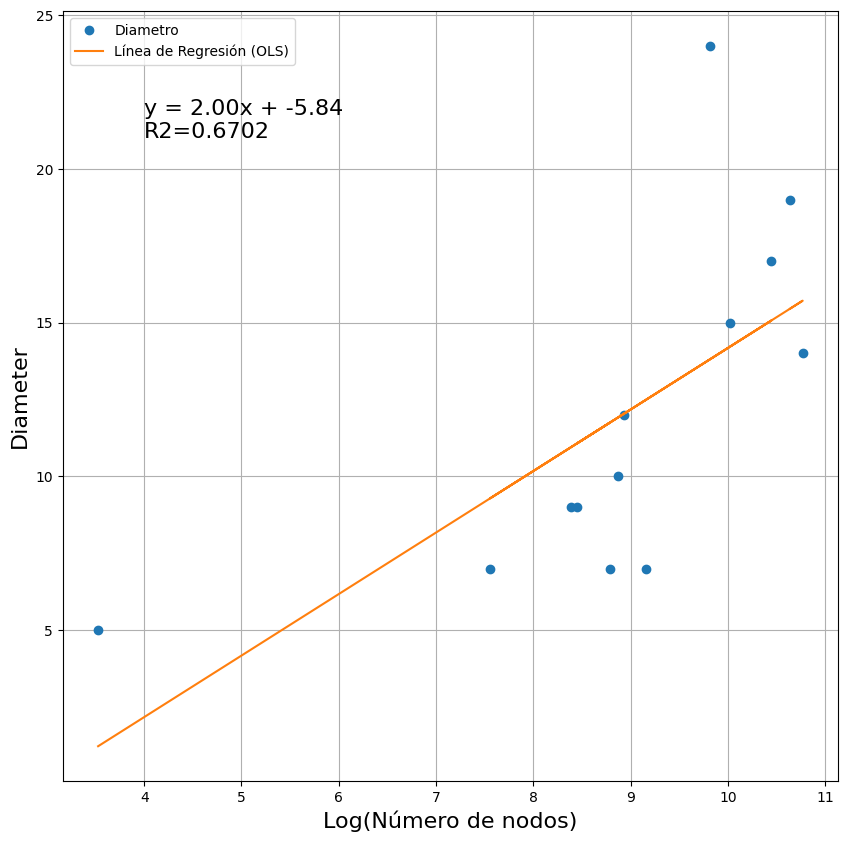

In [33]:
plt.figure(figsize=(10,10))

plt.plot(np.log(num_nodos), diametros, 'o', label="Diametro")

coeficientes = np.polyfit(np.log(num_nodos), diametros, 1)
linea = np.poly1d(coeficientes)


plt.plot(np.log(num_nodos), linea(np.log(num_nodos)), label="Línea de Regresión (OLS)")

# Add labels and legend
plt.xlabel("Log(Número de nodos)", fontsize=16)
plt.ylabel("Diameter", fontsize=16)

plt.text(4, 21, f"y = {coeficientes[0]:.2f}x + {coeficientes[1]:.2f}\nR2={np.corrcoef(np.log(num_nodos),diametros)[0,1]:.4f}", fontsize=16)
plt.legend()
plt.grid()
plt.show()

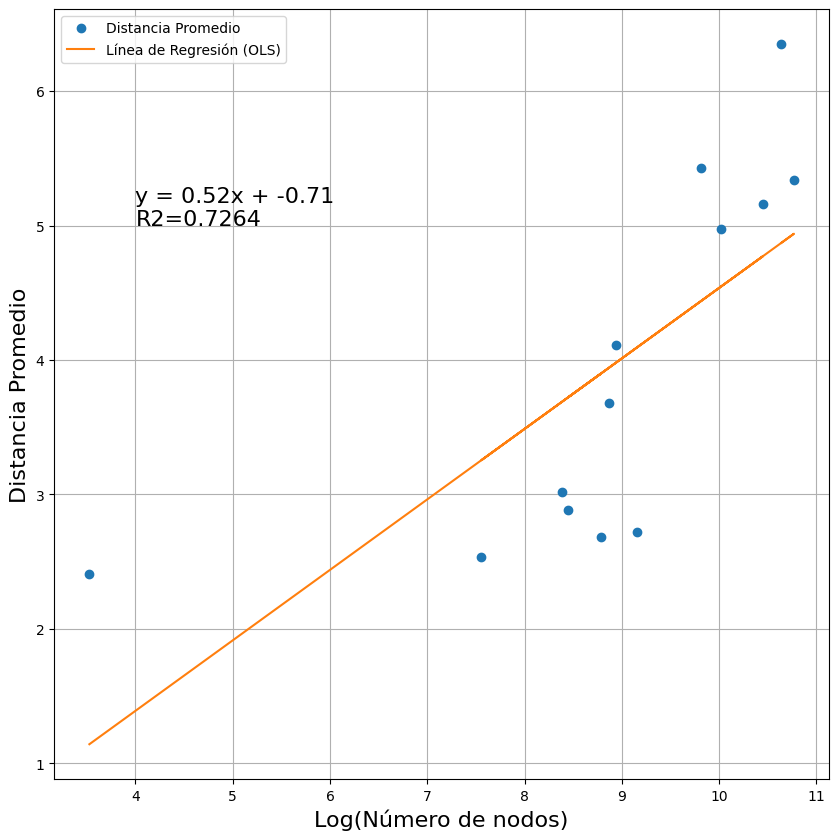

In [34]:
plt.figure(figsize=(10,10))

plt.plot(np.log(num_nodos), dist_promedio, 'o', label="Distancia Promedio")

coeficientes_2 = np.polyfit(np.log(num_nodos), dist_promedio, 1)
linea_2 = np.poly1d(coeficientes_2)


plt.plot(np.log(num_nodos), linea_2(np.log(num_nodos)), label="Línea de Regresión (OLS)")

# Add labels and legend
plt.xlabel("Log(Número de nodos)", fontsize=16)
plt.ylabel("Distancia Promedio", fontsize=16)

plt.text(4, 5, f"y = {coeficientes_2[0]:.2f}x + {coeficientes_2[1]:.2f}\nR2={np.corrcoef(np.log(num_nodos),dist_promedio)[0,1]:.4f}", fontsize=16)
plt.legend()
plt.grid()

plt.show()

Como puede verse anotado en ambos gráficos, el $R^2$ como medida de capacidad predictiva de una variable sobre otra de forma lineal es de $0.67$ en un caso y $0.73$ en el otro. Lo que hace pensar que la función logaritmo es buen predictor de estas métricas, lo que es consistente con la hipótesis de mundo pequeño.

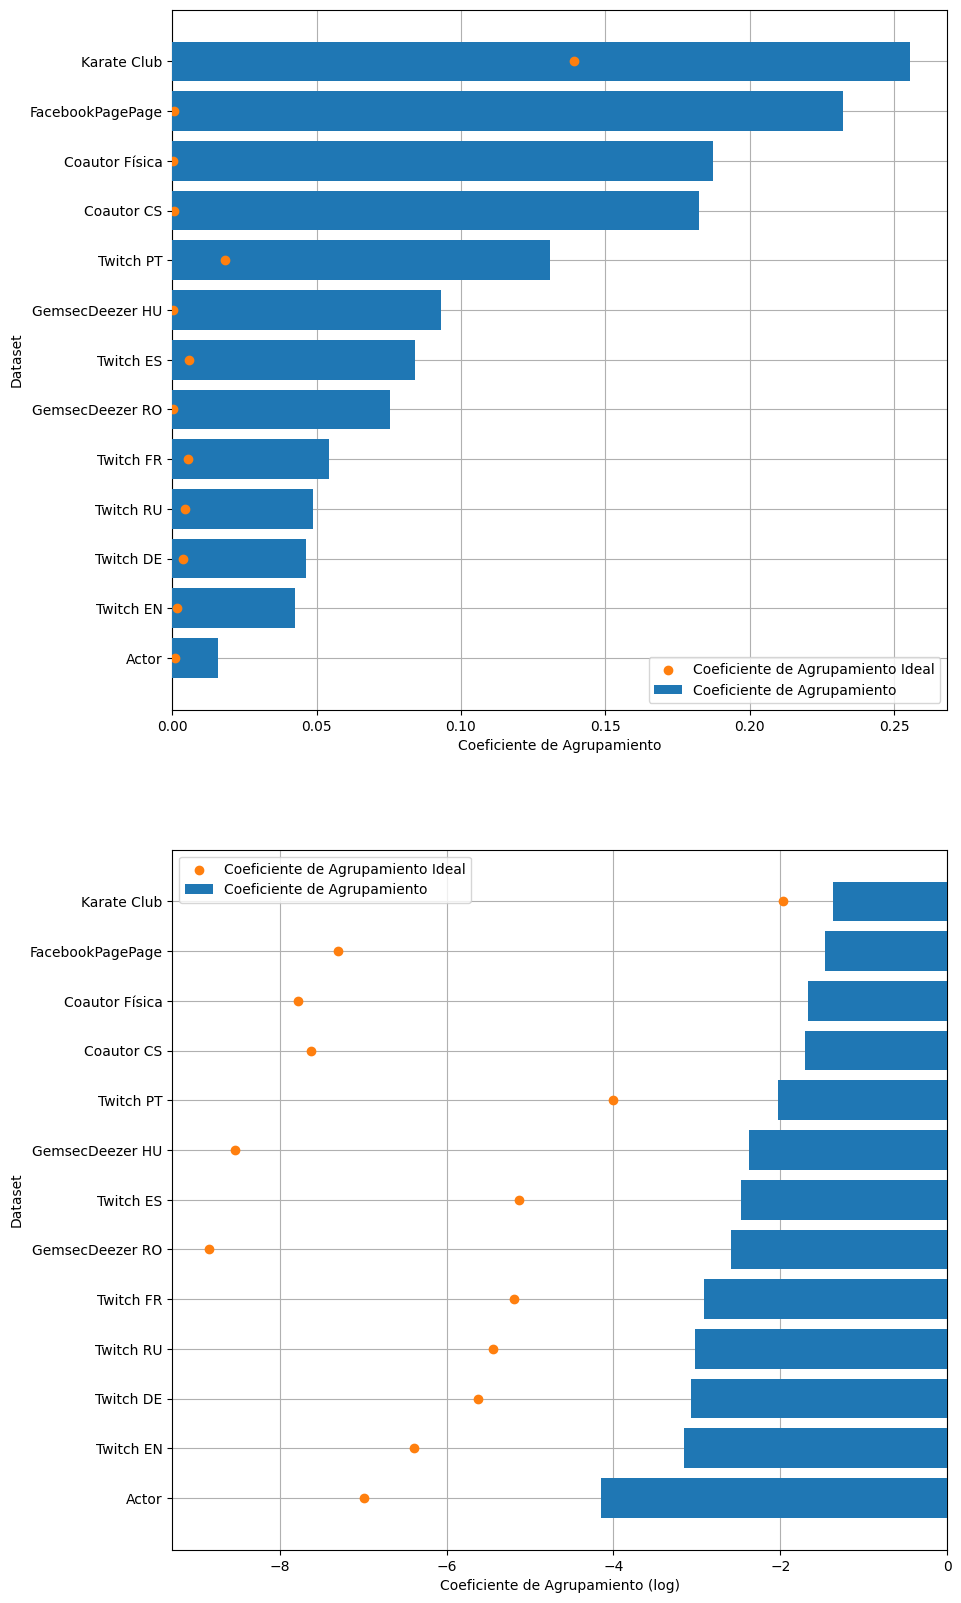

In [40]:
fig, ax = plt.subplots(2,1,figsize=(10,20))

nombres = sorted(nombres, key=lambda x: resultados[x][4])
valores = np.array( [resultados[nombre][4] for nombre in nombres])
ax[0].barh(nombres, valores , zorder=3, label="Coeficiente de Agrupamiento")

ideales = np.array([resultados[nombre][1]/(resultados[nombre][0]*(resultados[nombre][0]-1)/2) for nombre in nombres])

ax[0].scatter(ideales, range(len(nombres)), zorder=4, label="Coeficiente de Agrupamiento Ideal", alpha=1)

ax[0].set_ylabel("Dataset")
ax[0].set_xlabel("Coeficiente de Agrupamiento")
ax[0].legend()
ax[0].grid(True, zorder=0)

ax[1].barh(nombres, np.log(valores), zorder=3, label="Coeficiente de Agrupamiento")

ax[1].scatter(np.log(ideales), range(len(nombres)), zorder=4, label="Coeficiente de Agrupamiento Ideal", alpha=1)

ax[1].set_ylabel("Dataset")
ax[1].set_xlabel("Coeficiente de Agrupamiento (log)")
ax[1].legend()
ax[1].grid(True, zorder=0)



A su vez, vemos que todos los grafos tienen un coeficiente de agrupamiento mayor al de un grafo aleatorio de Erdos-Renyi con la misma cantidad de nodos y aristas, lo que nos sugiere que todos cumplen la propiedad de mundo pequeño.


El gráfico en escala logarítmica permite ver como hay órdenes de magnitud de diferencia entre el coeficiente de agrupamiento y el de un grafo aleatorio de Erdos-Renyi, y también entre los coeficientes normalizados de distintos grafos.

# Persistencia de la propiedad de Mundo Pequeño <a id="persistencia"></a>

Como idea innovadora de este trabajo práctico propongo ver si la propiedad de ser mundo pequeño se mantiene al retirar aristas. Para eso, para los datasets chicos (menos de 100K aristas) voy a formar una grilla de proporciones de aristas y para cada proporción voy a generar una población de subgrafos con ese porcentaje de aristas y voy a realizar el mismo análisis para cada uno de esos subgrafos.

Por tanto, los grafos excluidos son los siguientes:

In [16]:
for (k,v) in resultados.items():
    if v[1] > 100000:
        print(f"El grafo {k} tiene {v[1]} aristas")

El grafo Coautor Física tiene 247962 aristas
El grafo Twitch DE tiene 162636 aristas
El grafo Twitch FR tiene 119215 aristas
El grafo FacebookPagePage tiene 171002 aristas
El grafo GemsecDeezer HU tiene 222887 aristas
El grafo GemsecDeezer RO tiene 125826 aristas


In [17]:
chicos = list(filter(
    lambda G: G[1].ecount()<=100000,
    [(resultado, resultados[resultado][-2]) for resultado in resultados]))
# chicos

Y se utilizan en la siguiente parte del análisis los siguientes grafos:

In [18]:
for (name, G) in chicos:
    print(f"El grafo {name} tiene {G.ecount()} aristas")

El grafo Karate Club tiene 78 aristas
El grafo Actor tiene 26752 aristas
El grafo Coautor CS tiene 81894 aristas
El grafo Twitch EN tiene 42450 aristas
El grafo Twitch ES tiene 64030 aristas
El grafo Twitch PT tiene 33211 aristas
El grafo Twitch RU tiene 41689 aristas


In [19]:
prop_aristas = [0.99,0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1,0.05,0.01,0.001,0.0001]
# prop_aristas = list(map(str, prop_aristas))

Hay que tener en cuenta que como al eliminar aristas el grafo puede dejar de ser conexo, se calcularán las métricas sobre la componente conexa más grande del subgrafo resultante. Además, considero que el tamaño de esta componente conexa es una métrica interesante a analizar y graficar.

In [30]:
ns = [nombre for (nombre, G) in chicos]
set(ns[:4])
jb.dump(set(ns[:4]),"variables/calculados.pkl")

['variables/calculados.pkl']

In [ ]:
from tqdm.notebook import tqdm
from time import perf_counter as time

try:
    diametros = jb.load("variables/diametros.pkl")
    distancias = jb.load("variables/distancias.pkl")
    tamanios = jb.load("variables/tamanios.pkl")
    agrupamientos = jb.load("variables/agrupamientos.pkl")
    calculados = jb.load("variables/calculados.pkl")
except:
    num_samples = 20
    diametros = [ [ [[],[]], [[],[]] ] for _ in chicos]
    distancias = [ [ [[],[]], [[],[]] ] for _ in chicos]
    tamanios = [ [ [[],[]], [[],[]] ] for _ in chicos]
    agrupamientos = [ [ [[],[]], [[],[]] ] for _ in chicos]
    calculados = set()

bar = tqdm(total = len(chicos) * len(prop_aristas) * num_samples)
np.random.seed(0) # Reproducibilidad

for i, (nombre, G) in enumerate(chicos):
        
    if nombre in calculados:
        bar.update(len(prop_aristas) * num_samples)
        continue
    
    conexas = num_samples
    pre_prop = 1    
    for j, prop_arista in enumerate(prop_aristas):
        # print(f"quito {num_aristas=}")
        # print(aristas)
        for k in range(num_samples):
            sample_prop = np.random.uniform(float(prop_arista), pre_prop)
            num_aristas = int(G.ecount()*(1-sample_prop))
            
            t0 = time()
            aristas = np.random.choice(G.ecount(), num_aristas, replace=False)
            G_copy = G.copy()
            #print(G_copy.ecount())
            G_copy.delete_edges(aristas)
            #print(G_copy.ecount())
            mayor_cc = max(G_copy.components(), key=len)
            #print(f"{len(mayor_cc)} vs {G.vcount()} | {G_copy.is_connected()=}")
                
            conected = 1 

            if not G_copy.is_connected():
                conected = 0
                # print(f"La muestra {k} con {prop_arista=} no es conexa")
                G_copy = G_copy.subgraph(mayor_cc)
                    
            #    bar.update(1)
            #    bar.desc = f"Procesando {nombre} con {prop_arista*100}% de aristas: {k+1}/{num_samples}"
            #    tqdm.refresh(bar)   
            #    continue
                
            # t0 = time()
            diametro = 0
            distancia_promedio = 0
            diametro = G_copy.diameter()
            distancia_promedio = G_copy.average_path_length()
            diametros[i][conected][0].append(1-sample_prop)
            diametros[i][conected][1].append(diametro)
            distancias[i][conected][0].append(1-sample_prop)
            distancias[i][conected][1].append(distancia_promedio)
            tamanios[i][conected][0].append(1-sample_prop)
            tamanios[i][conected][1].append(G_copy.vcount()/G.vcount())
            agrupamientos[i][conected][0].append(1-sample_prop)
            agrupamientos[i][conected][1].append(G_copy.transitivity_undirected() * G_copy.vcount() * (G_copy.vcount()-1) / G_copy.ecount() / 2)



            #ax[i,0].points(num_aristas, diametro, 'o', color="blue")
            #ax[i,1].points(num_aristas, distancia_promedio, 'o', color="red")
            t1 = time()
            bar.update(1)
            bar.desc = f"Procesando {nombre} con {float(prop_arista)*100}% de aristas: {k+1}/{num_samples} en {t1-t0:.8f} seg"
        #    tqdm.refresh(bar, nolock=True)   
        pre_prop = prop_arista

    calculados.add(nombre)
    jb.dump(diametros, "variables/diametros.pkl")
    jb.dump(distancias, "variables/distancias.pkl")
    jb.dump(tamanios, "variables/tamanios.pkl")
    jb.dump(agrupamientos, "variables/agrupamientos.pkl")
    jb.dump(calculados, "variables/calculados.pkl")
    


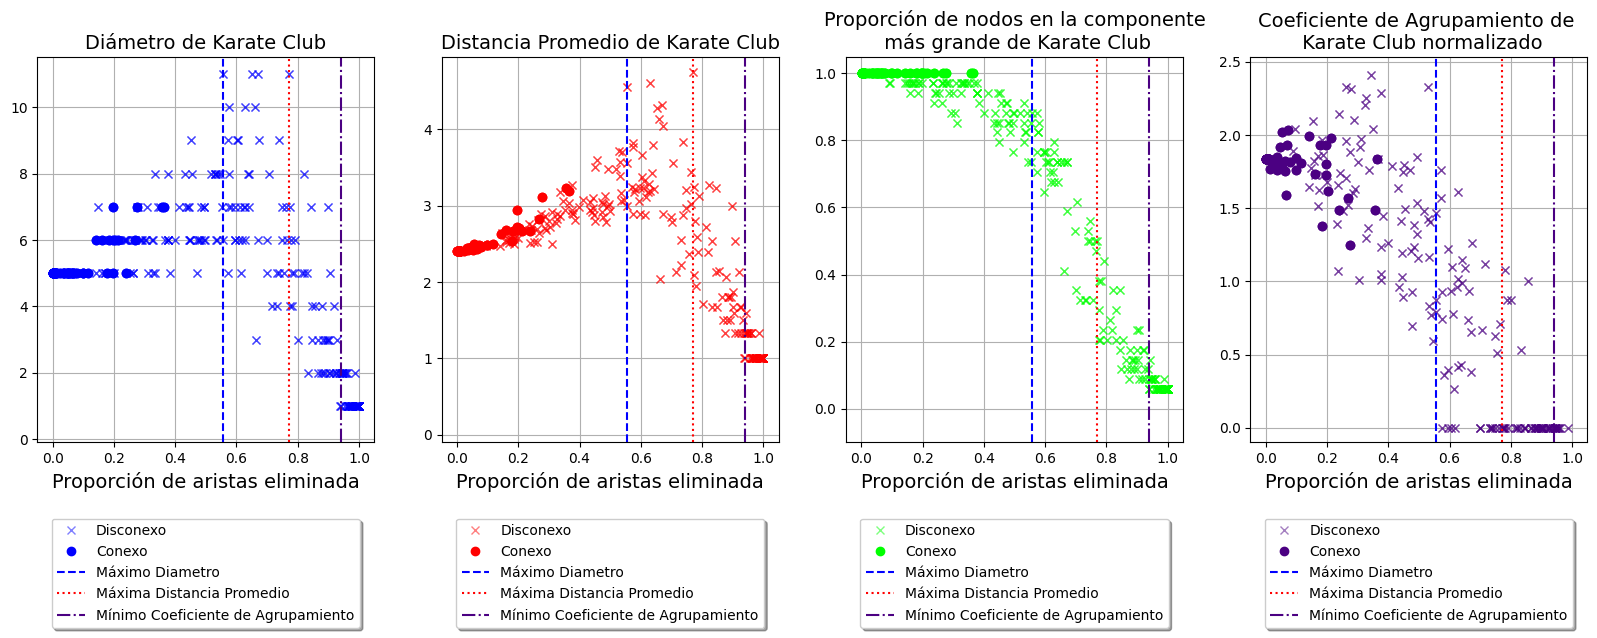

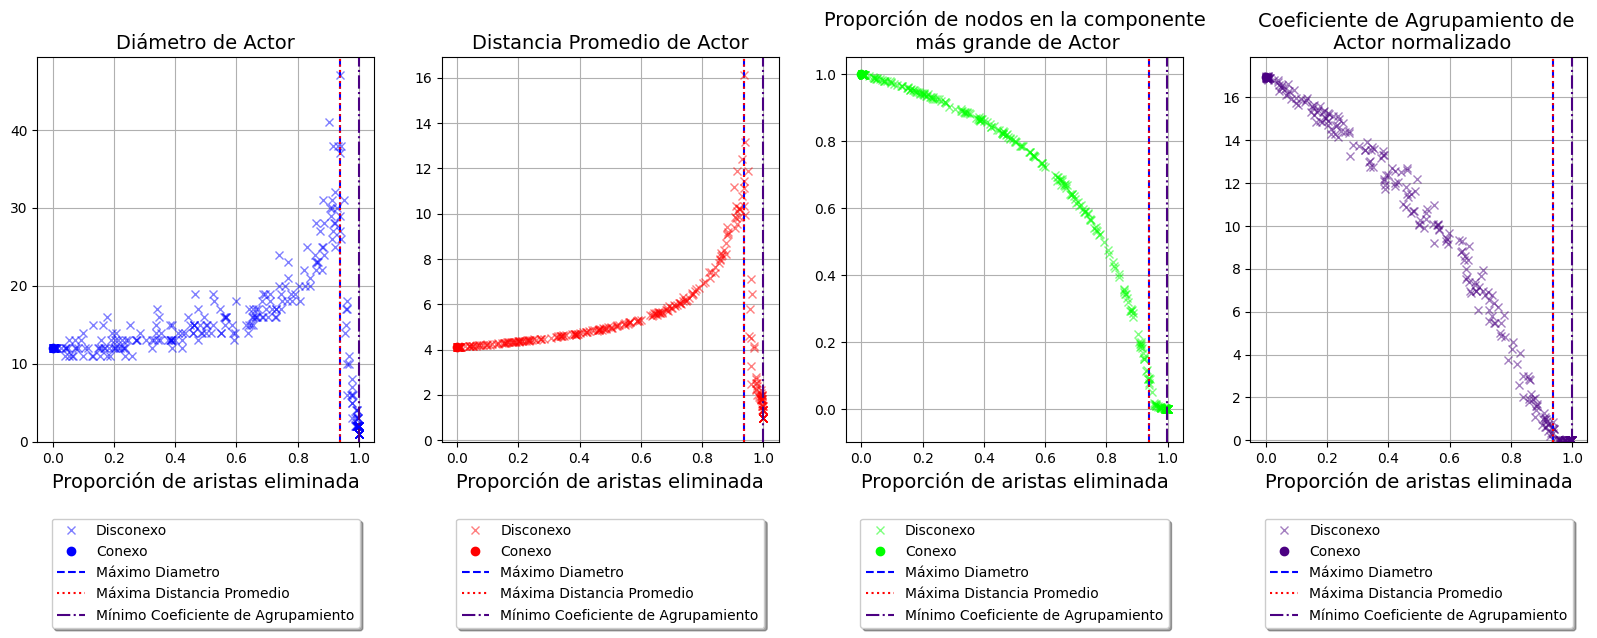

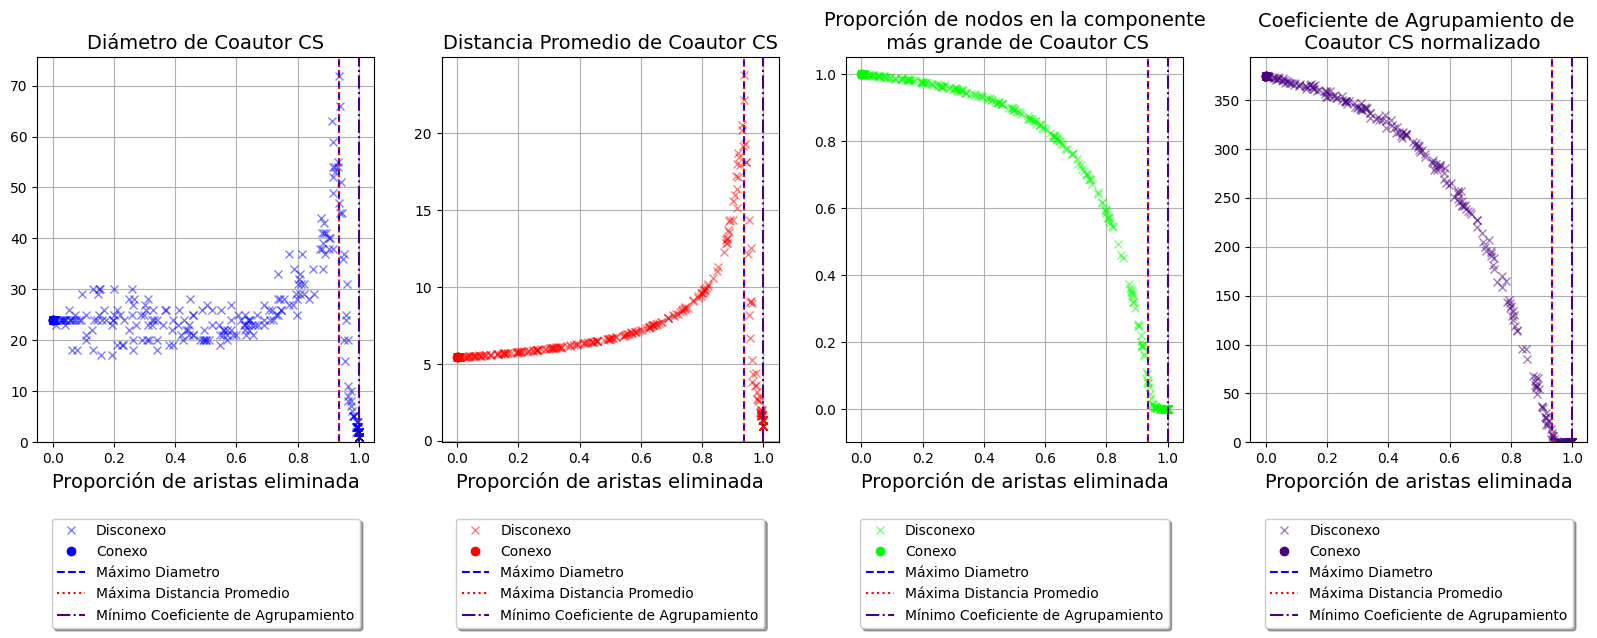

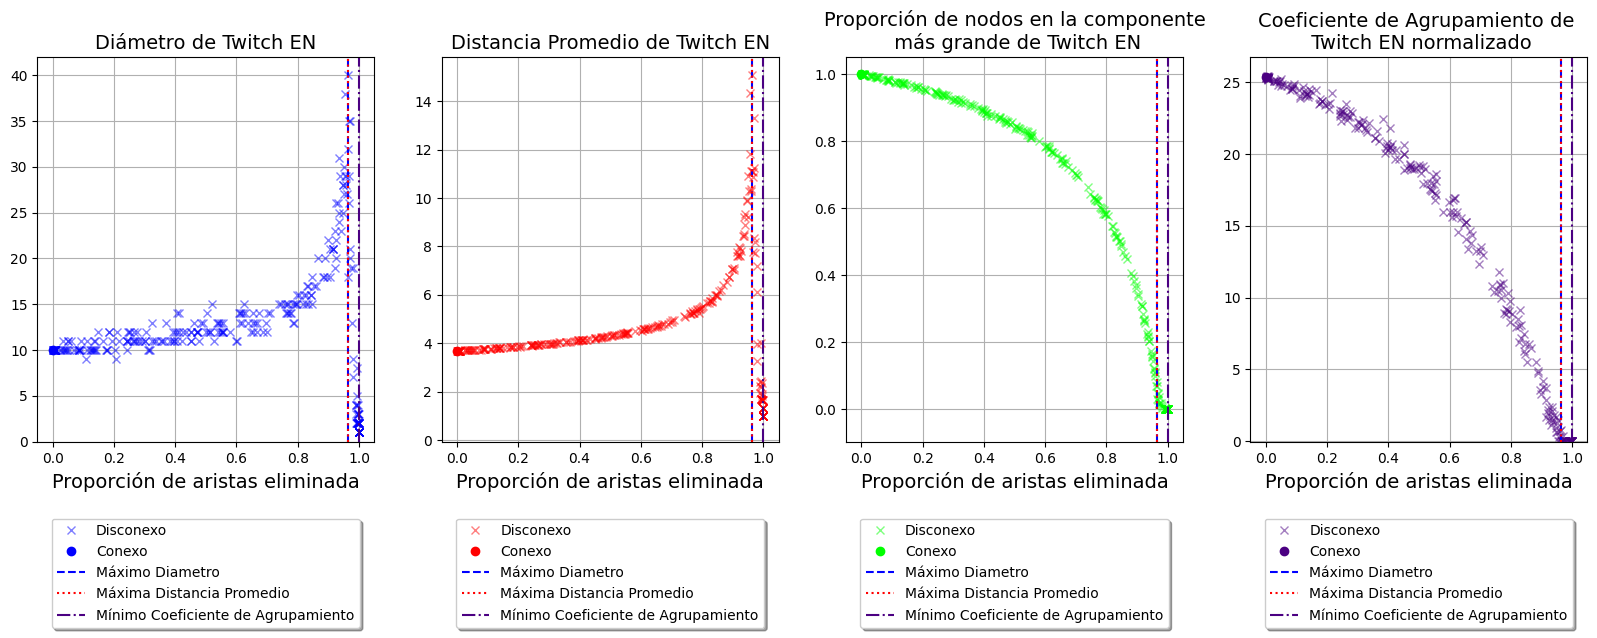

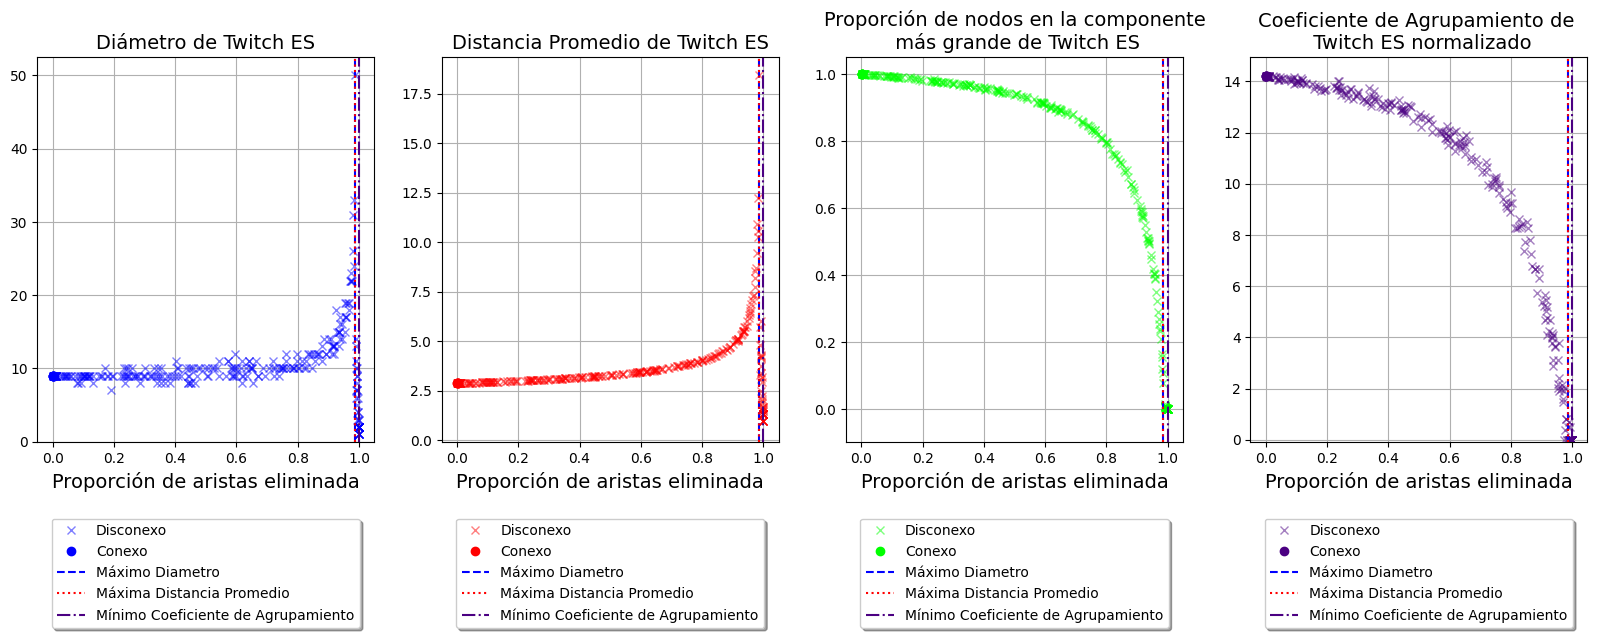

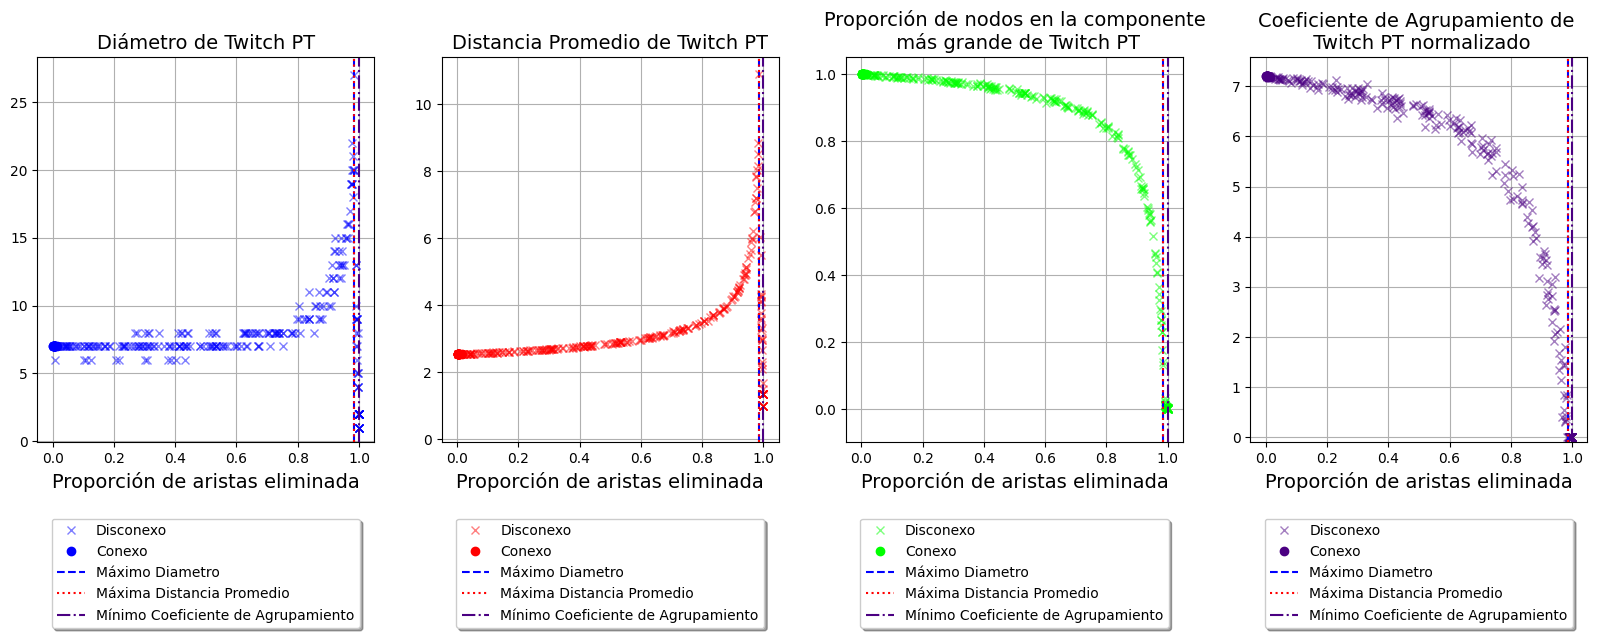

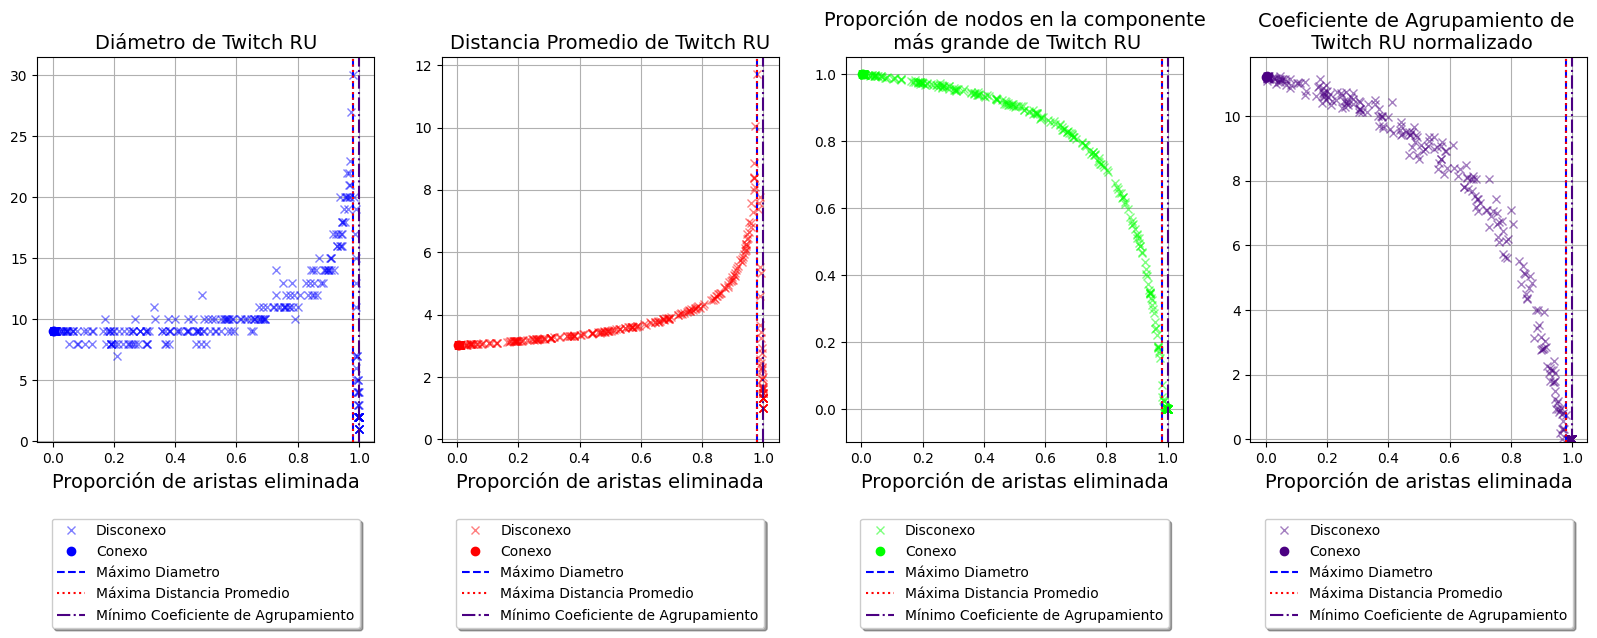

In [45]:
for i, (nombre, G) in enumerate(chicos):
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    for k, label in enumerate(("Disconexo","Conexo")):
        ch = 'o' if k == 1 else 'x'
        ax[0].plot(diametros[i][k][0], diametros[i][k][1], ch, color=(0,0,1,0.5+k/2), label=label)
        ax[1].plot(distancias[i][k][0], distancias[i][k][1], ch, color=(1,0,0,0.5+k/2), label=label)  
        ax[2].plot(tamanios[i][k][0], tamanios[i][k][1], ch, color=(0,1,0,0.5+k/2), label=label)
        ax[3].plot(agrupamientos[i][k][0], agrupamientos[i][k][1], ch, color=(75/255,0,130/255,0.5+k/2), label=label)
        
    d_max = np.argmax(diametros[i][0][1])
    dis_max = np.argmax(distancias[i][0][1])
    agrupo_min = np.argmin(agrupamientos[i][0][1])    

    for k in range(4):
        ax[k].set_xlabel("Proporción de aristas eliminada", fontsize=14)
        ax[k].grid()
        # ax[i,k].set_xticks(prop_aristas)
        ax[k].axvline(diametros[i][0][0][d_max], color="blue", linestyle="--", label = "Máximo Diametro")
        ax[k].axvline(distancias[i][0][0][dis_max], color="red", linestyle=":", label = "Máxima Distancia Promedio")
        ax[k].axvline(agrupamientos[i][0][0][agrupo_min], color=(75/255,0,130/255), linestyle="-.", label = "Mínimo Coeficiente de Agrupamiento")
        ax[k].legend(bbox_to_anchor=(0.5,-0.5), loc = "lower center", shadow = True)
        ax[k].set_ylim(-0.1, None)
        ax[k].set_xlim(-0.05,1.05)
    
    ax[0].set_title(f"Diámetro de {nombre}", fontsize=14)
    ax[1].set_title(f"Distancia Promedio de {nombre}", fontsize=14)
    ax[2].set_title(f"Proporción de nodos en la componente\n más grande de {nombre}", fontsize=14)
    ax[3].set_title(f"Coeficiente de Agrupamiento de \n {nombre} normalizado", fontsize=14)
    fig.show()    
plt.plot()
clear_output()

Lo que se puede apreciar en el gráfico anterior es que todos los grafos (salvo Karate por ser especialmente chico) siguen una dinámica similar donde el tamaño de la mayor componente conexa decrece más lentamente que la proporción de aristas conservadas, para posteriormente caer abruptamente. A su vez, el diámetro y la distancia promedio de la componente mayor crecen lentamente hasta que cerca del punto donde se conservan 0 aristas tienen un pico abrupto y luego caen rápidamente cuando la componente conexa mayor es muy chica.


Como se puede ver, las líneas punteadas azul y roja coinciden en todos los casos salvo Karate, es decir que los picos de las métricas Diámetro y Distancia Promedio se dan en el mismo caso para todos los grafos. Es decir, de todos los subgrafos generados eliminando subconjuntos aleatorios de las aristas, el que tiene mayor diámetro es el mismo que el que tiene mayor distancia promedio entre nodos.


La línea violeta, que indica en cuál caso se obtuvo el mínimo coeficiente de agrupamiento nor-ma-li-za-do, no coincide con las líneas roja y azul pero queda cerca en todos los casos. Es razonable dado que coincide con que al perder muchas aristas se deterioran todas las características del mundo pequeño. Como se puede ver, el coeficiente de agrupamiento tiene un comportamiento curiosamente similar al tamaño de la componente más grande.

# Comportamiento conjunto de las variables

Otra cosa que puede ser interesante ver es la distribución conjunta de las 4 variables calculadas, dando lugar a una grilla de 4x4 graficos para cada gráfo (es decir, el conjunto de subgráfos de ese gráfo):

- **Diámetro**

- **Distancia Promedio**

- **Tamaño componente mayor**

- **Coeficiente de agrupamiento normalizado**
  
  
Como al eliminar aristas es esperable que el grafo deje de ser conexo, por un lado es importante tener en cuenta que el diámetro y la distancia promedio se calcularan sobre

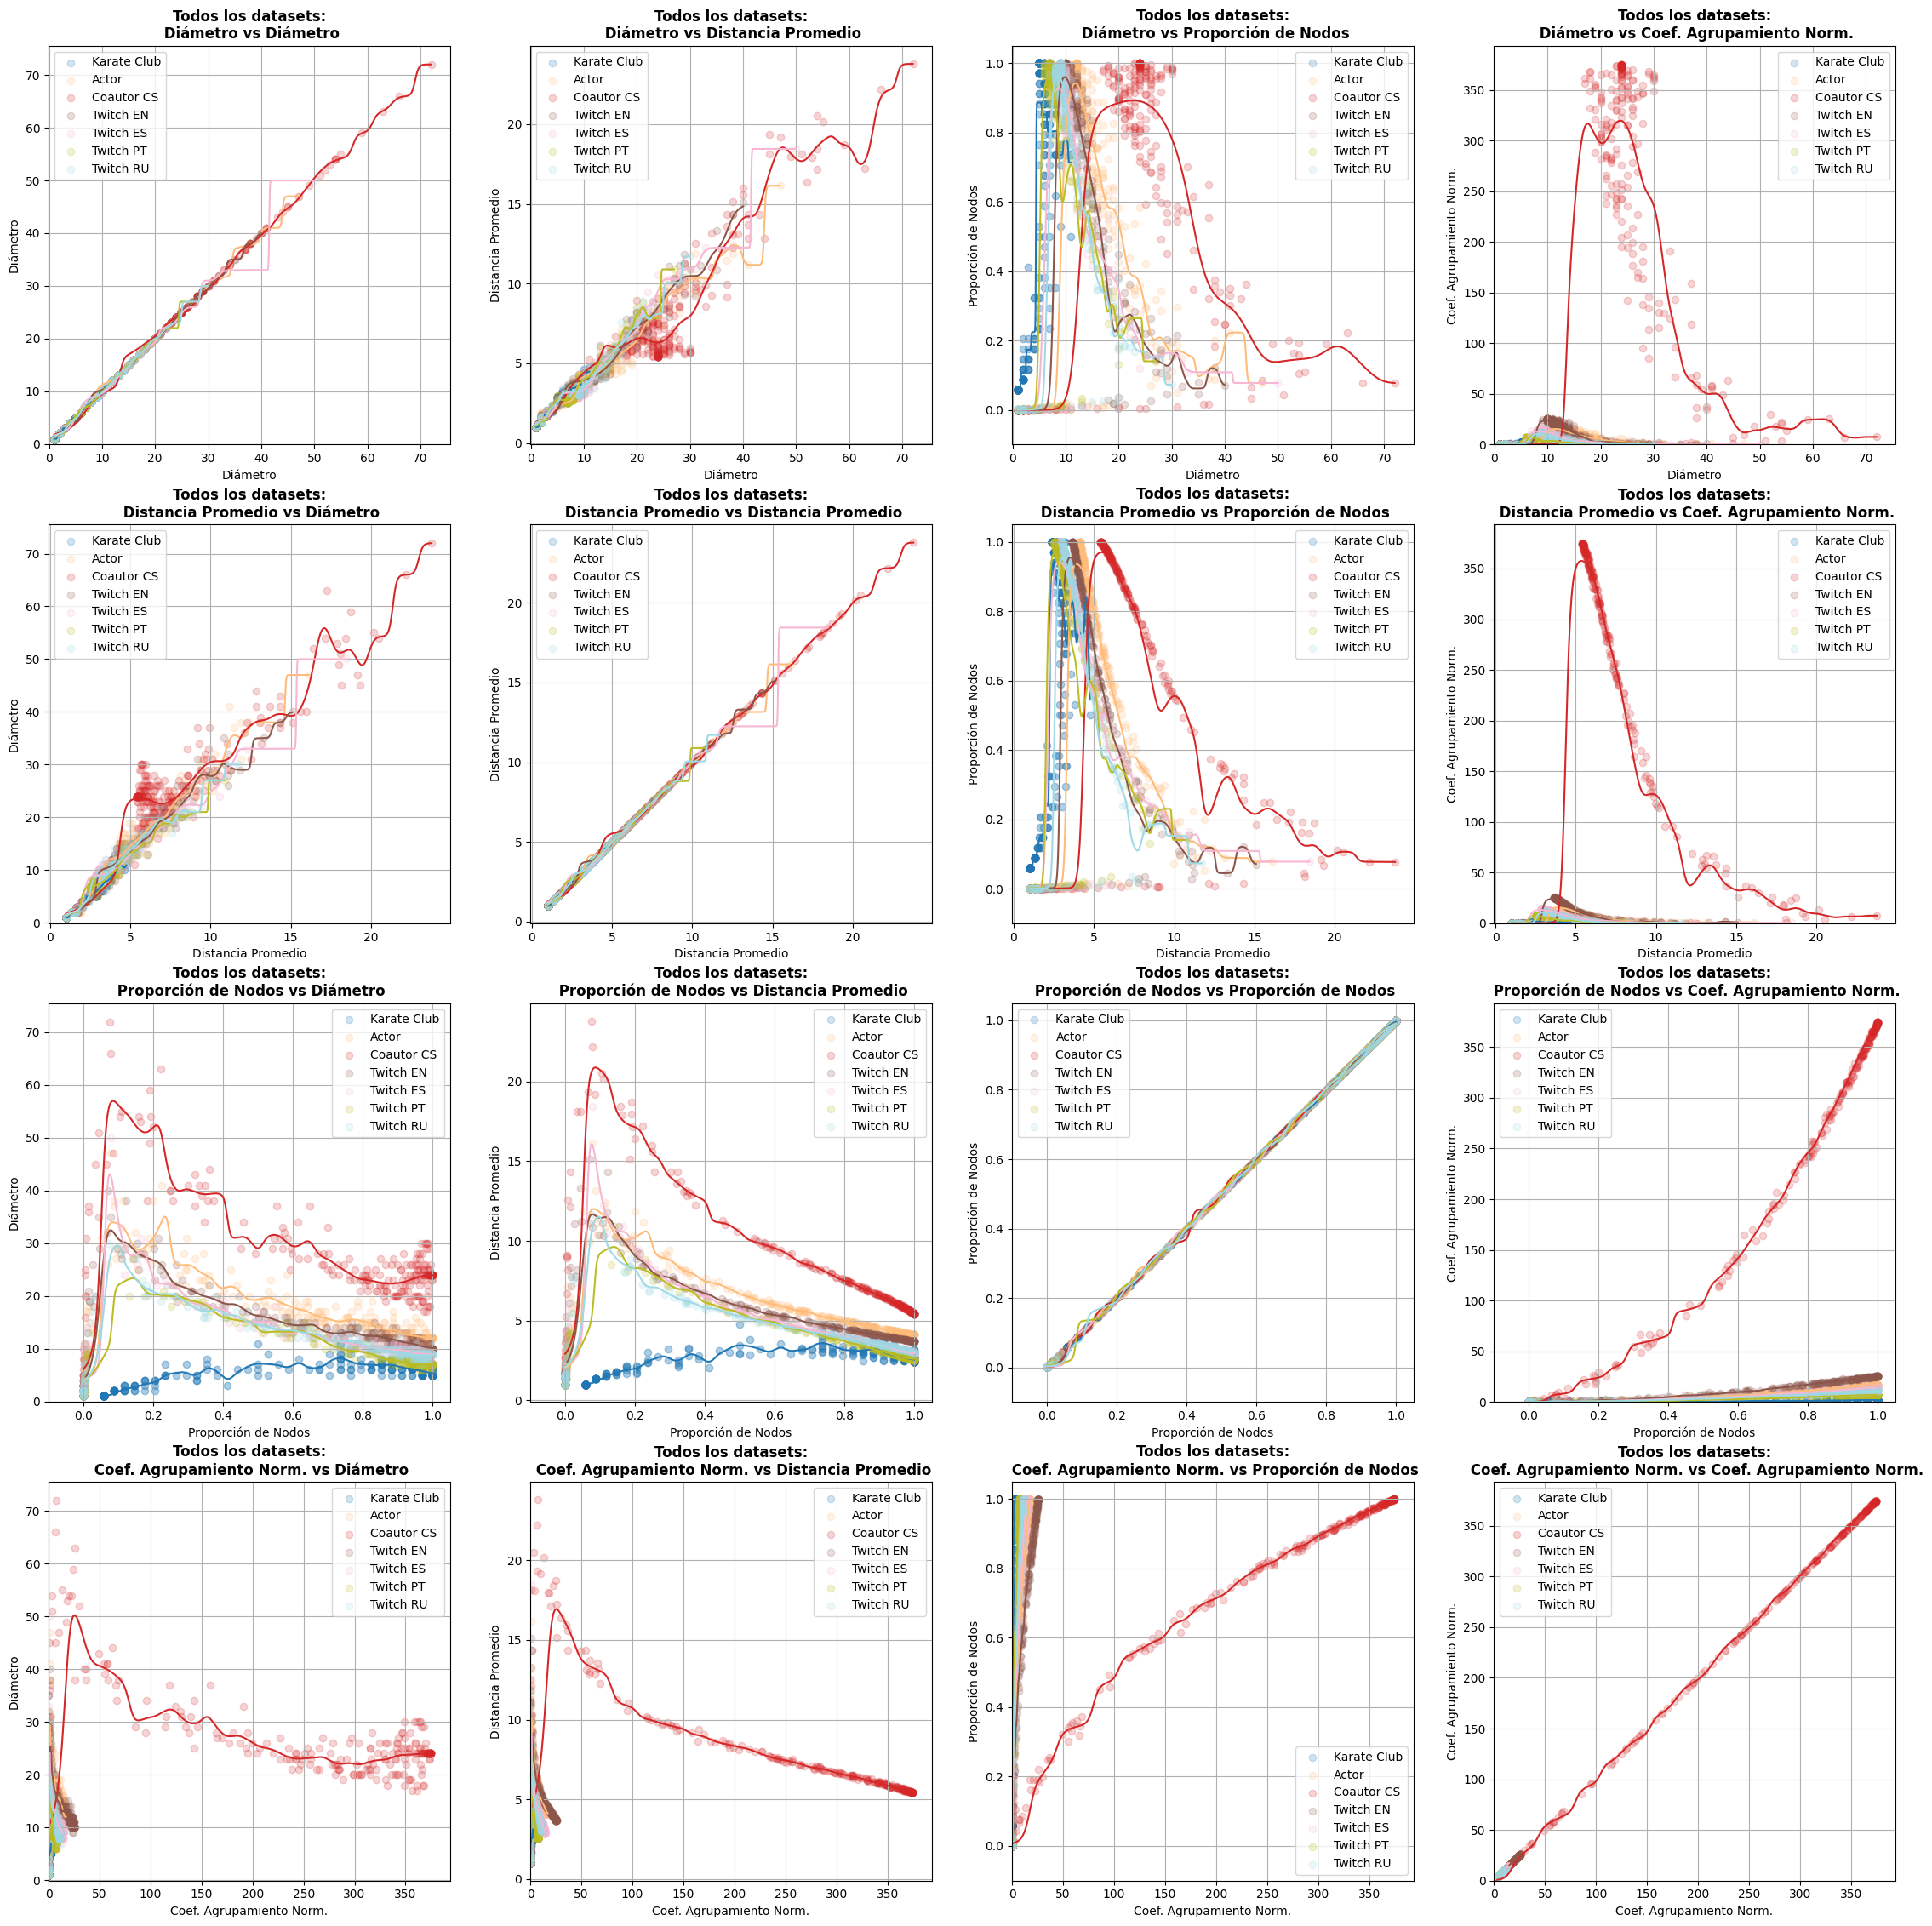

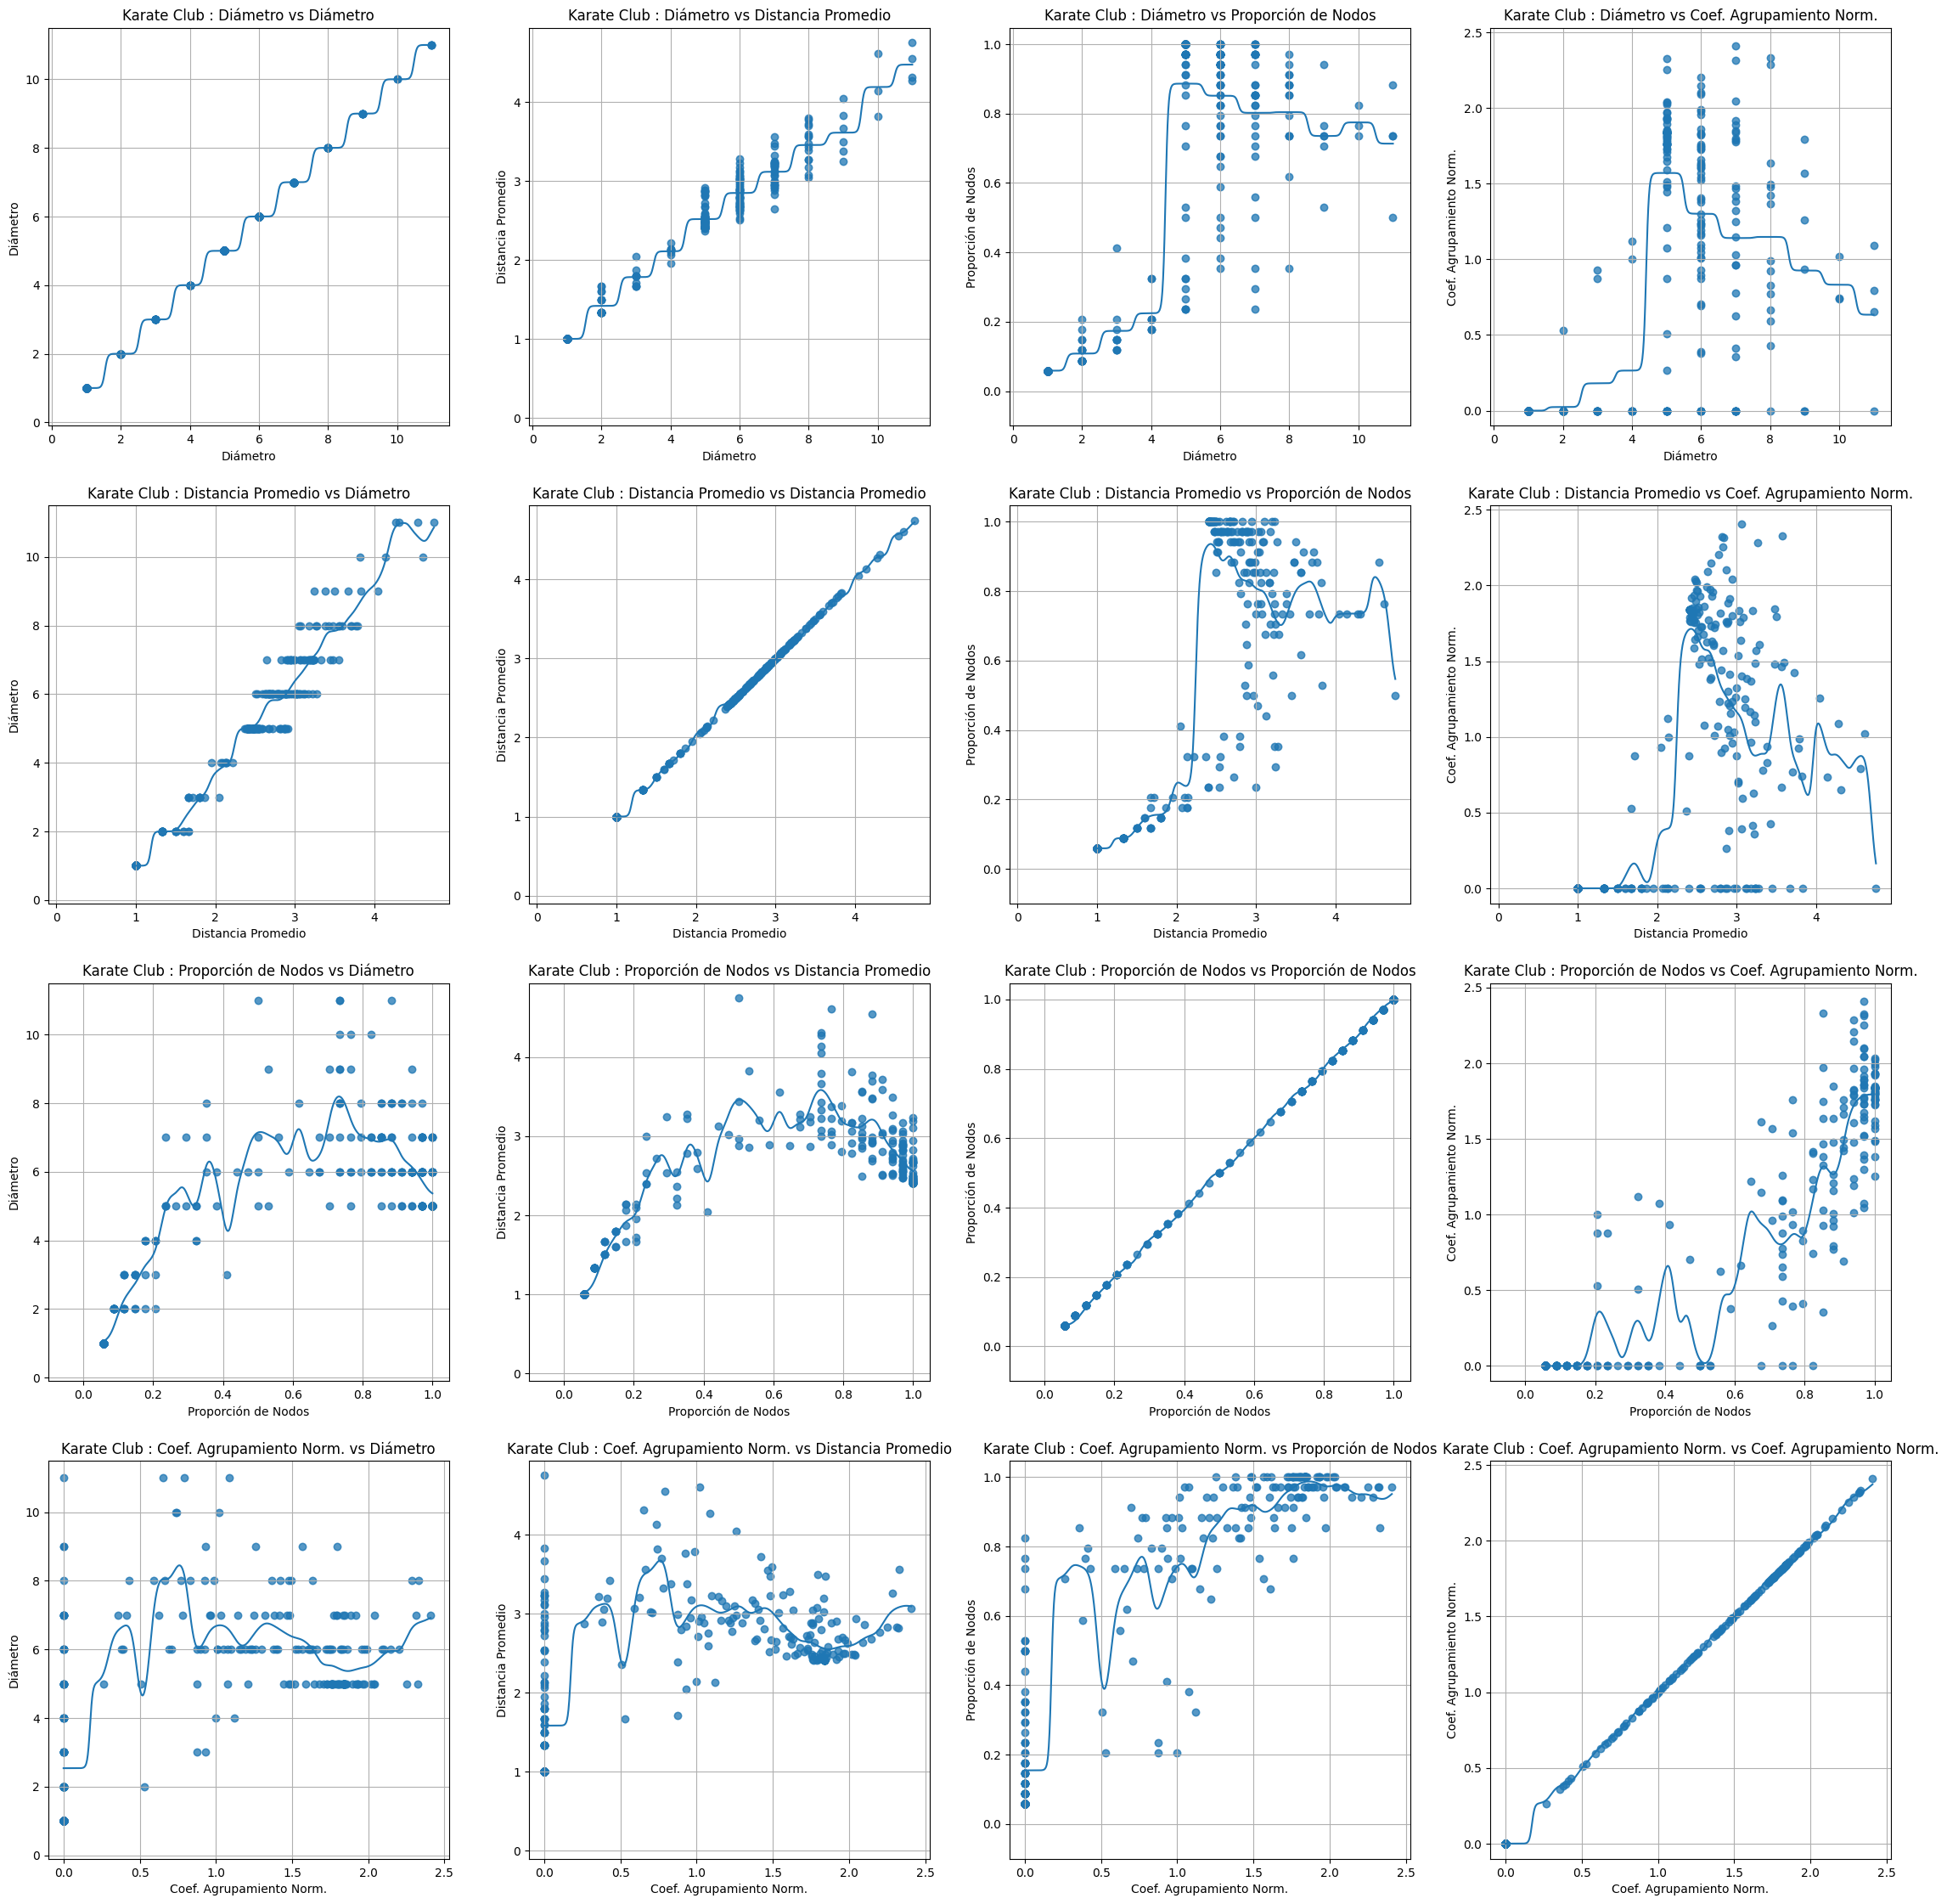

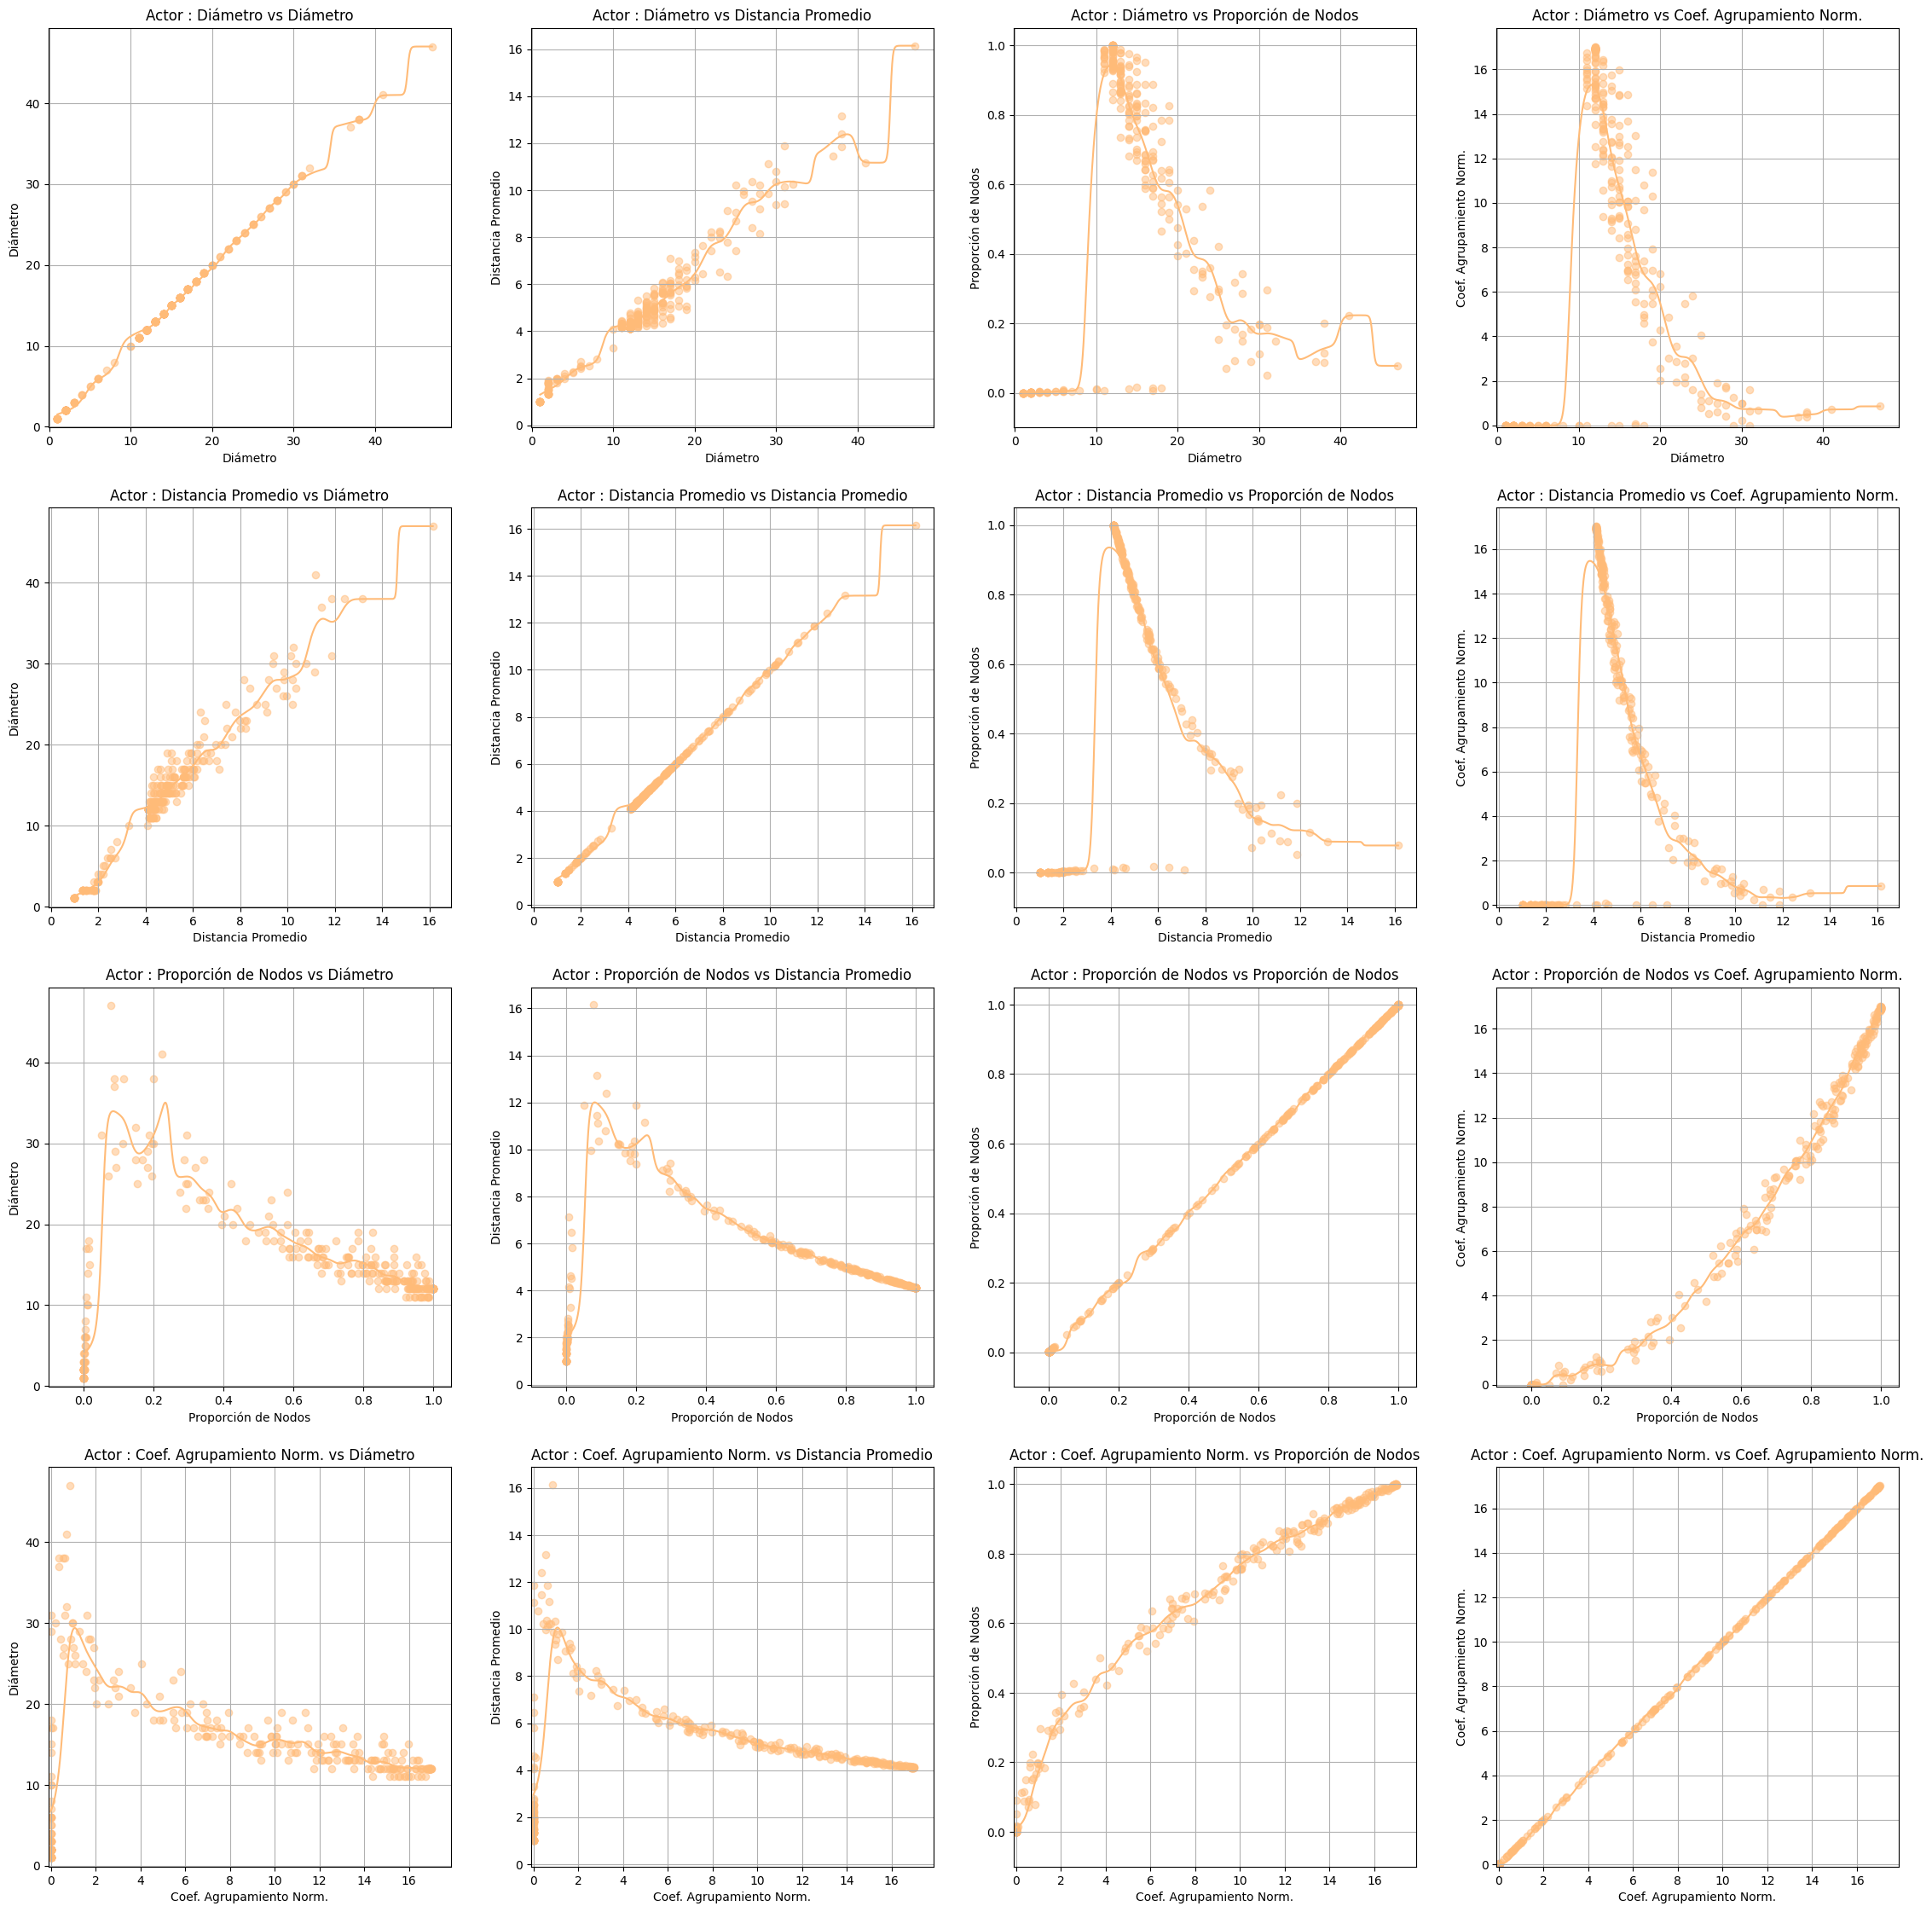

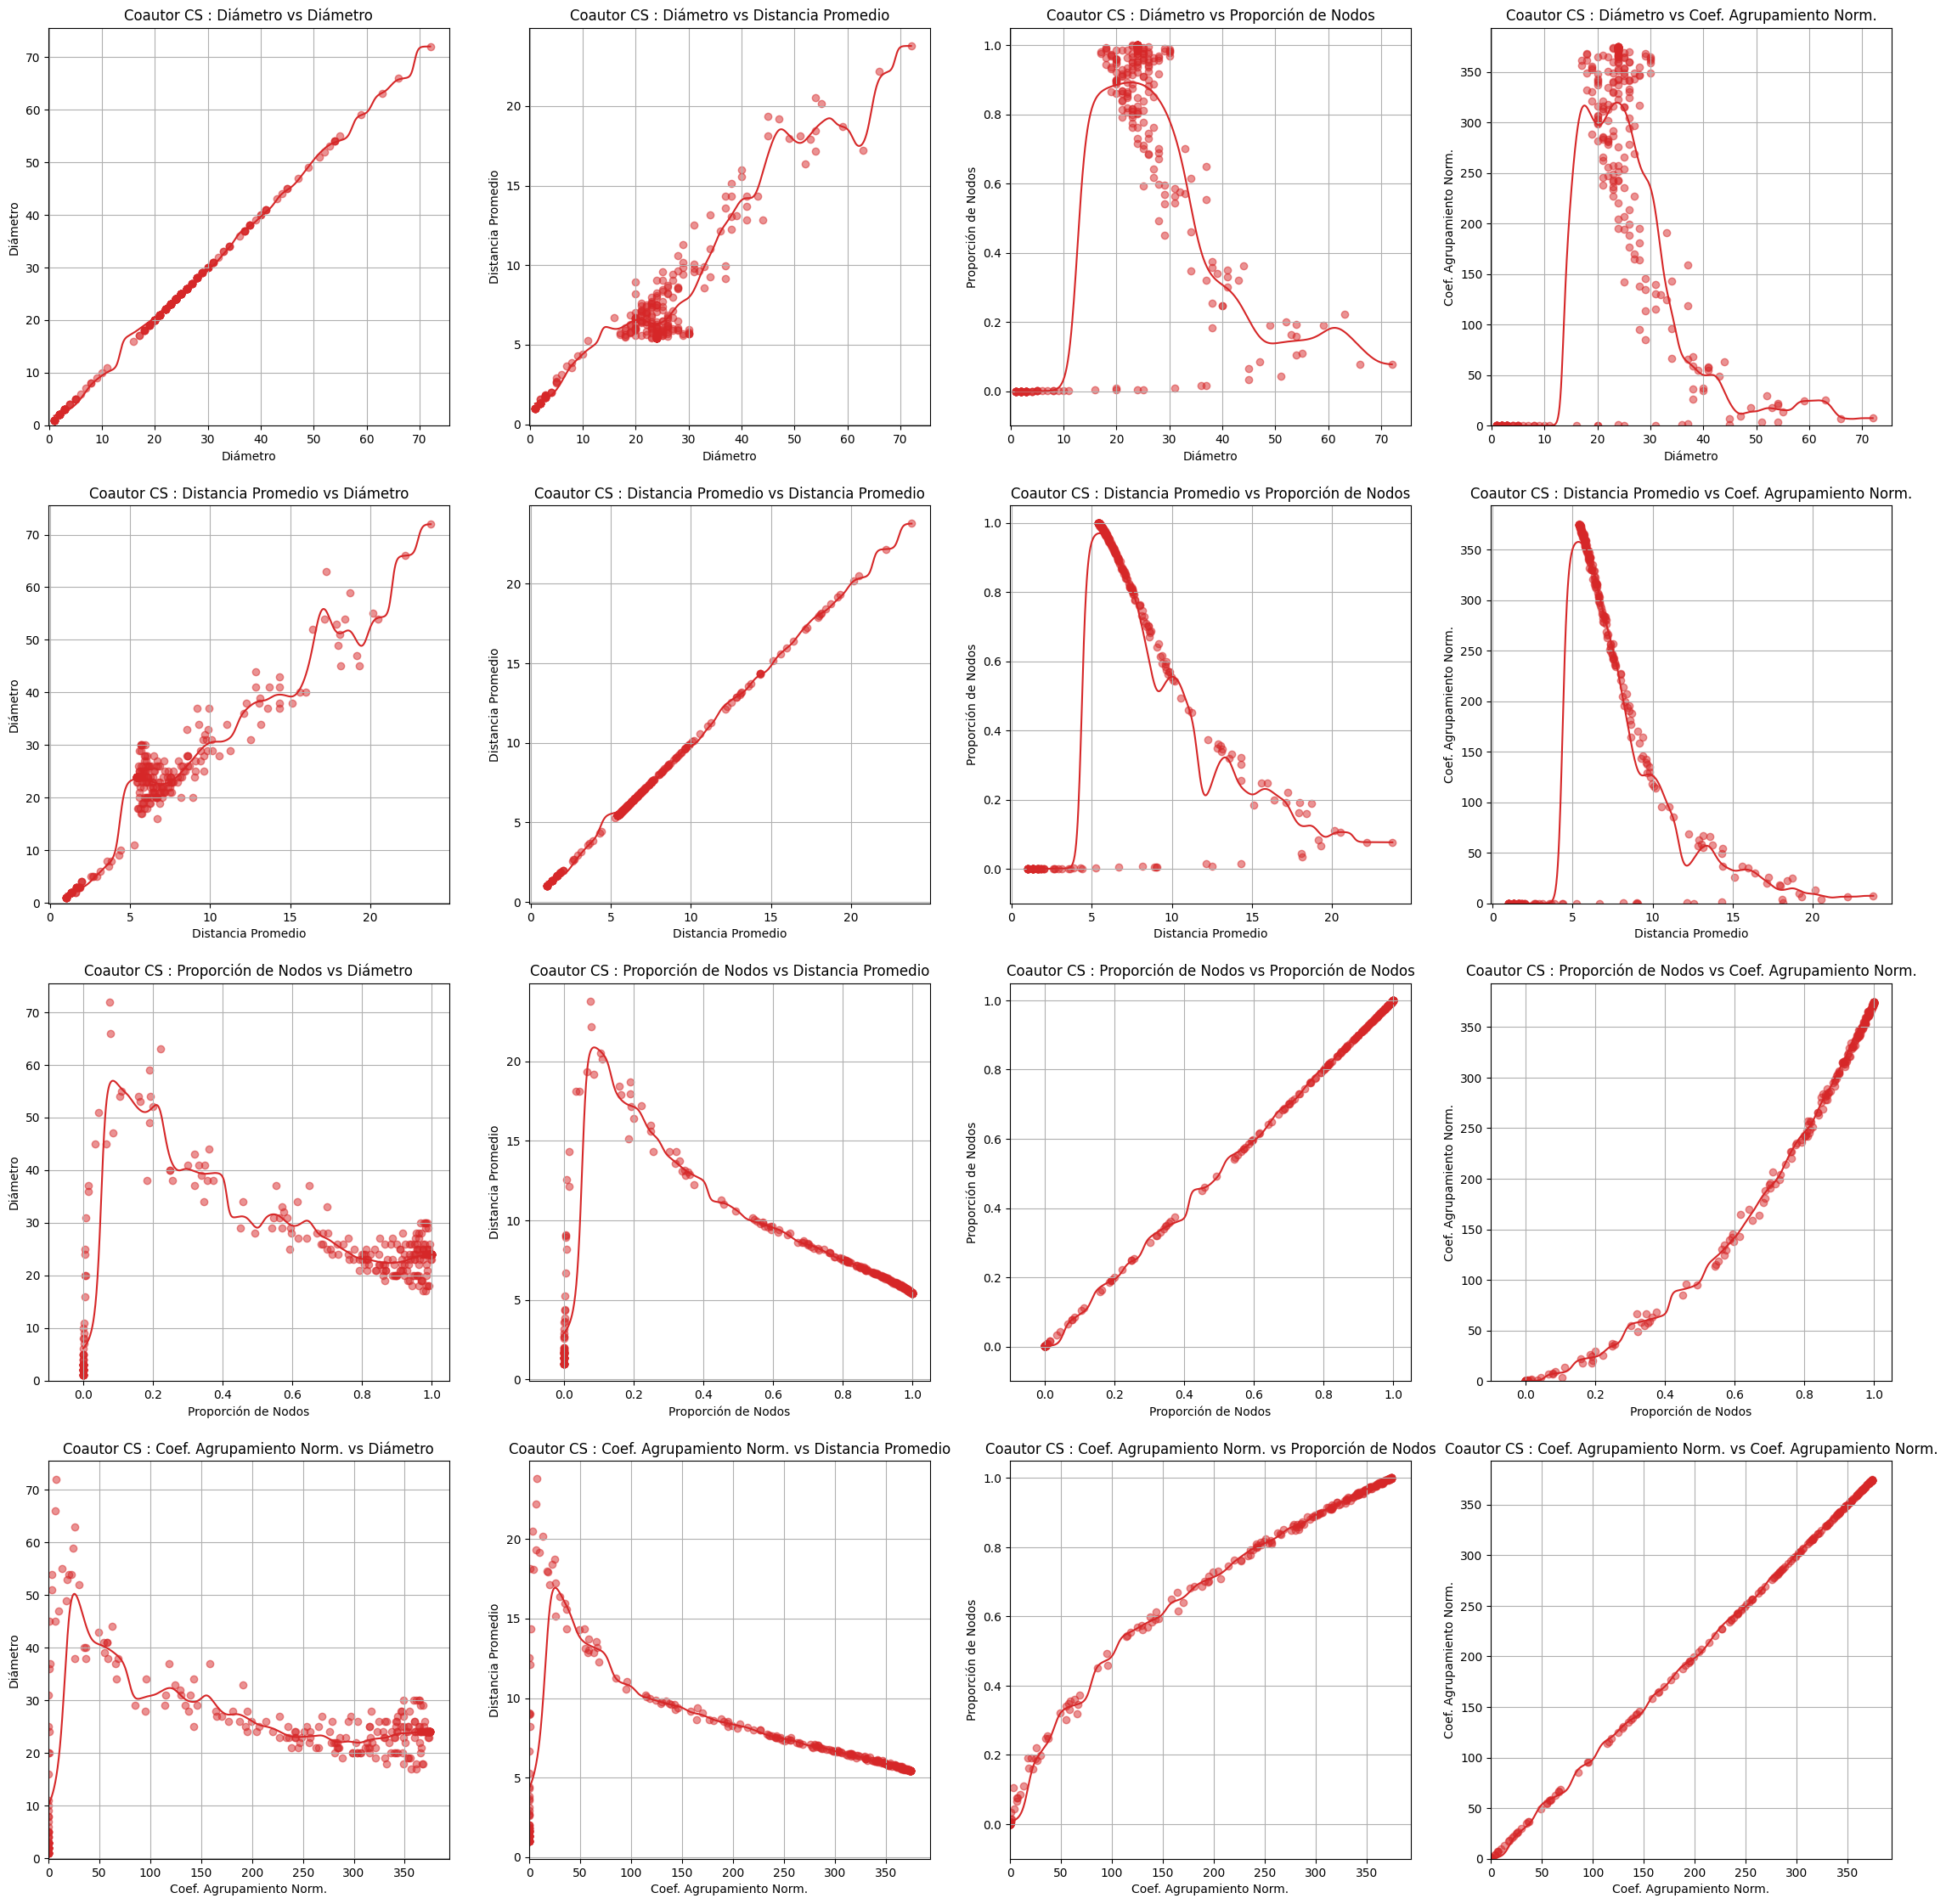

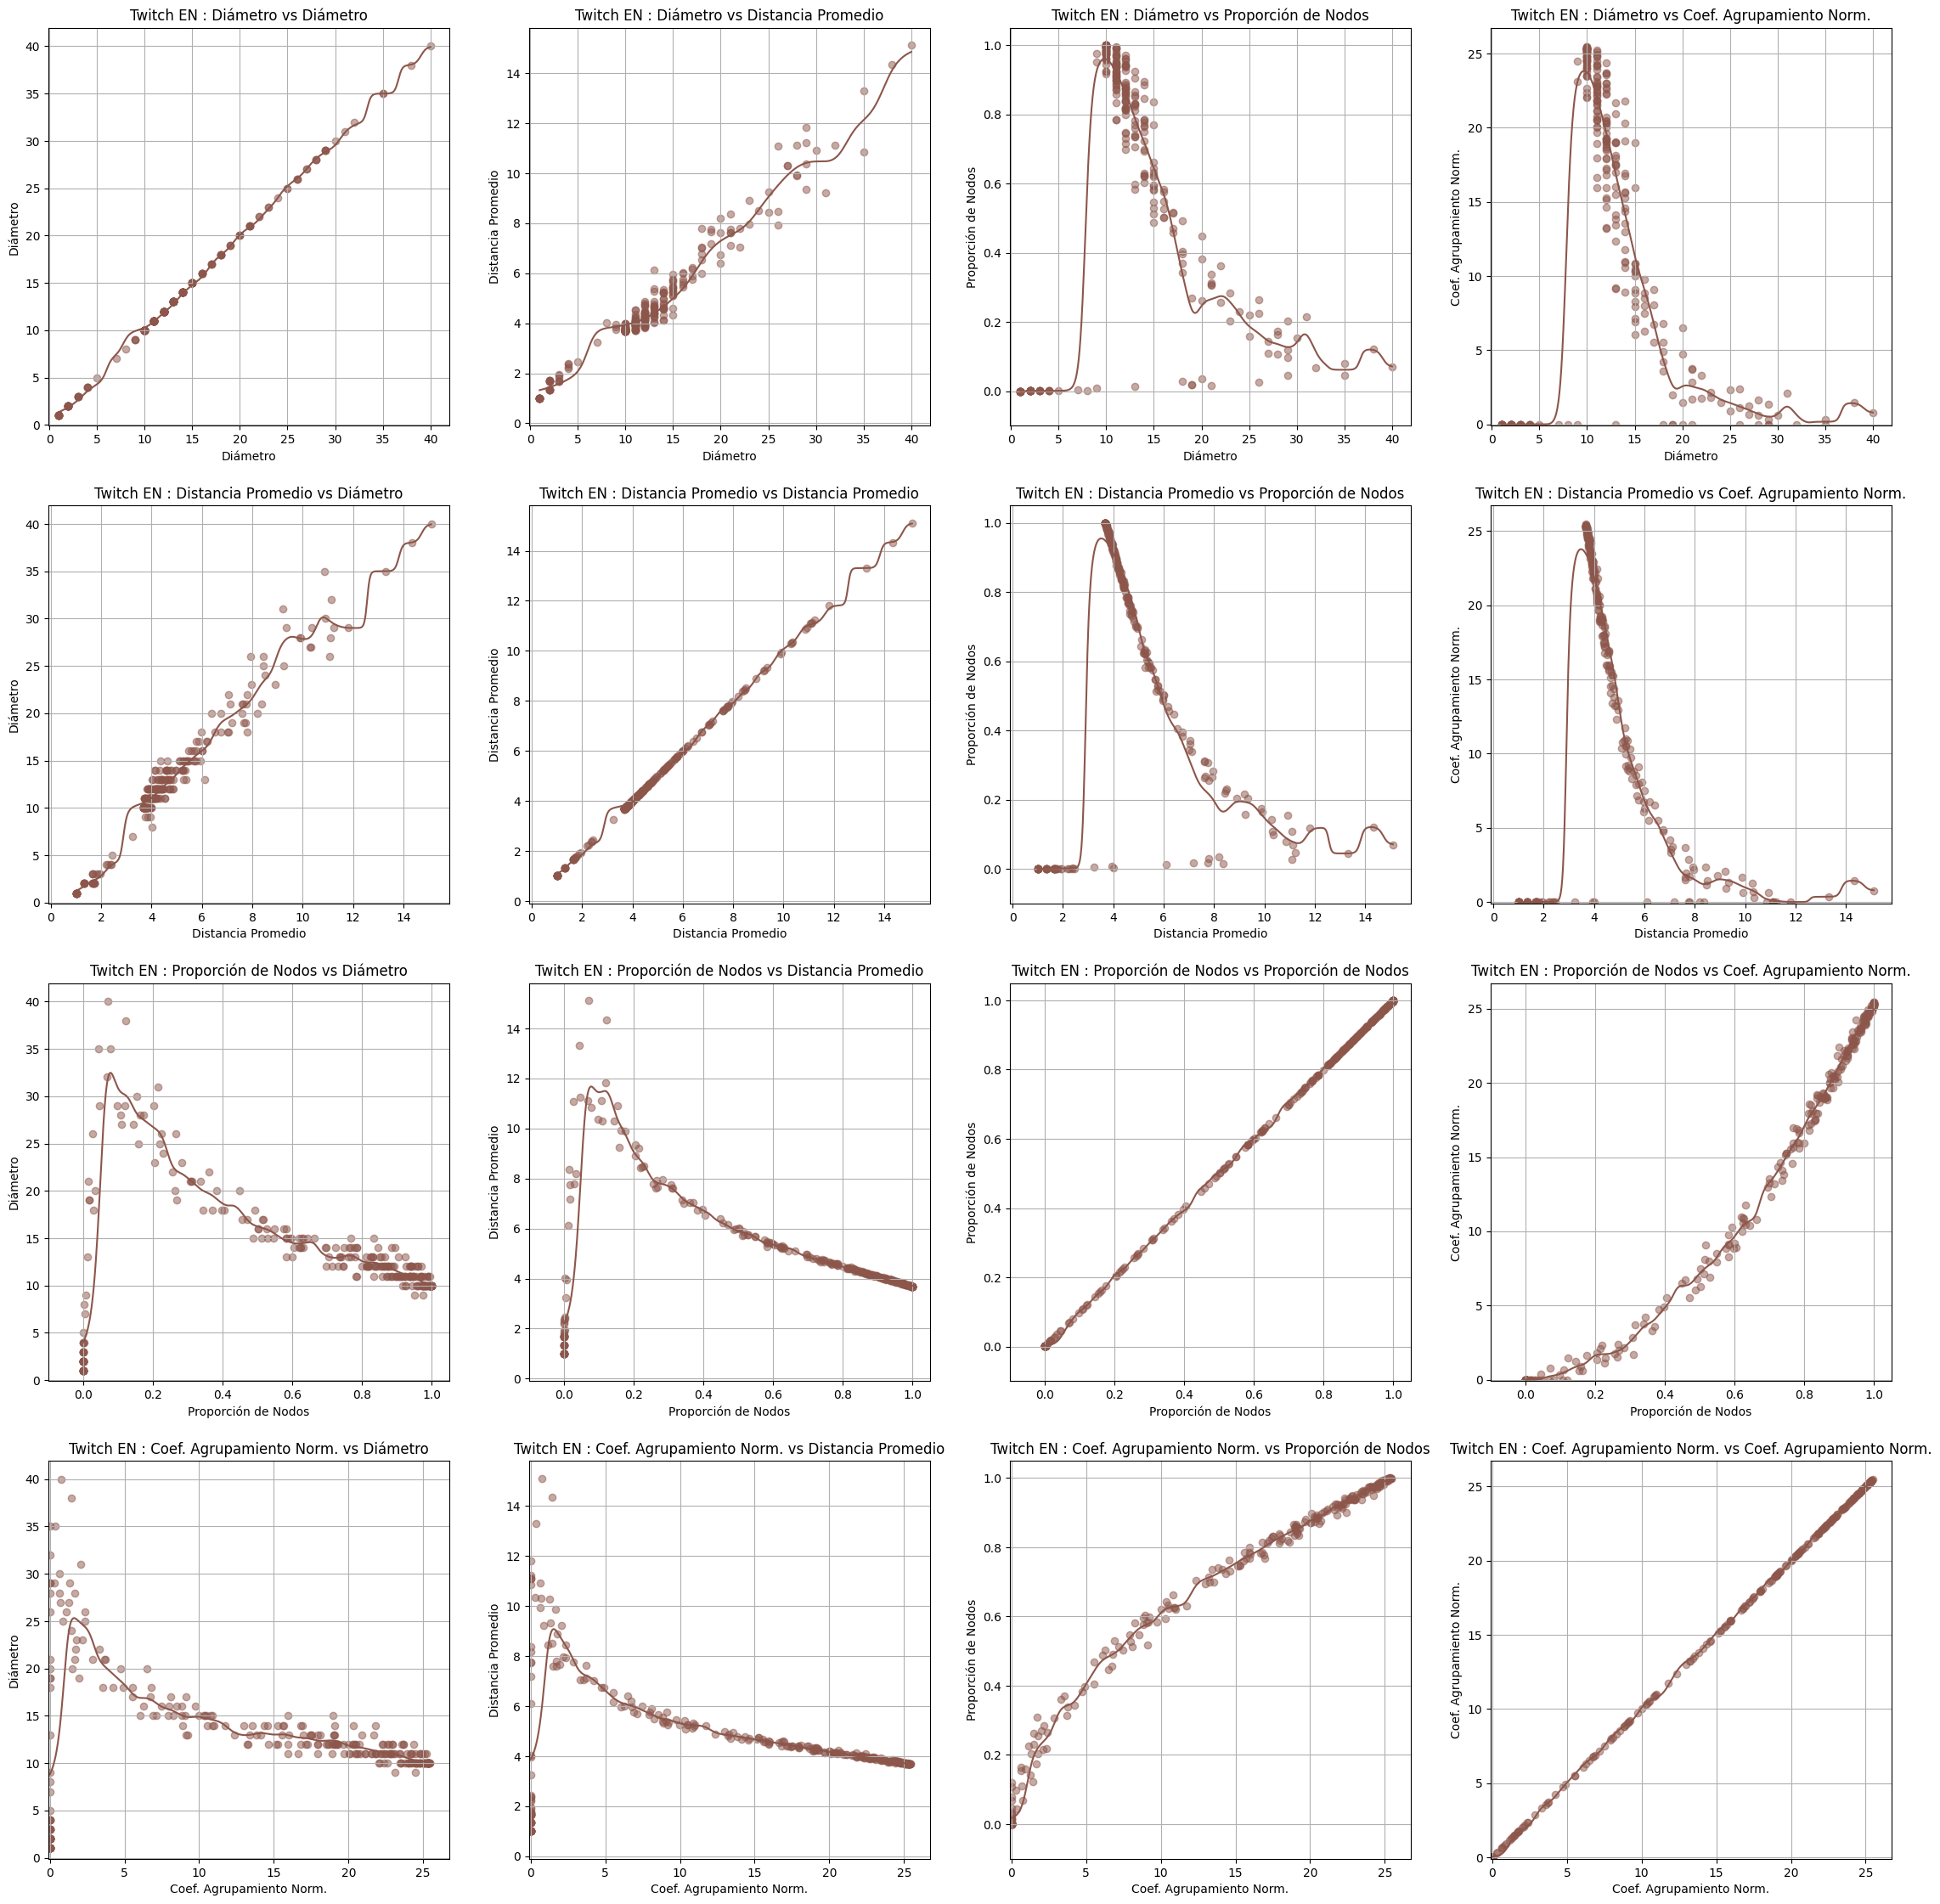

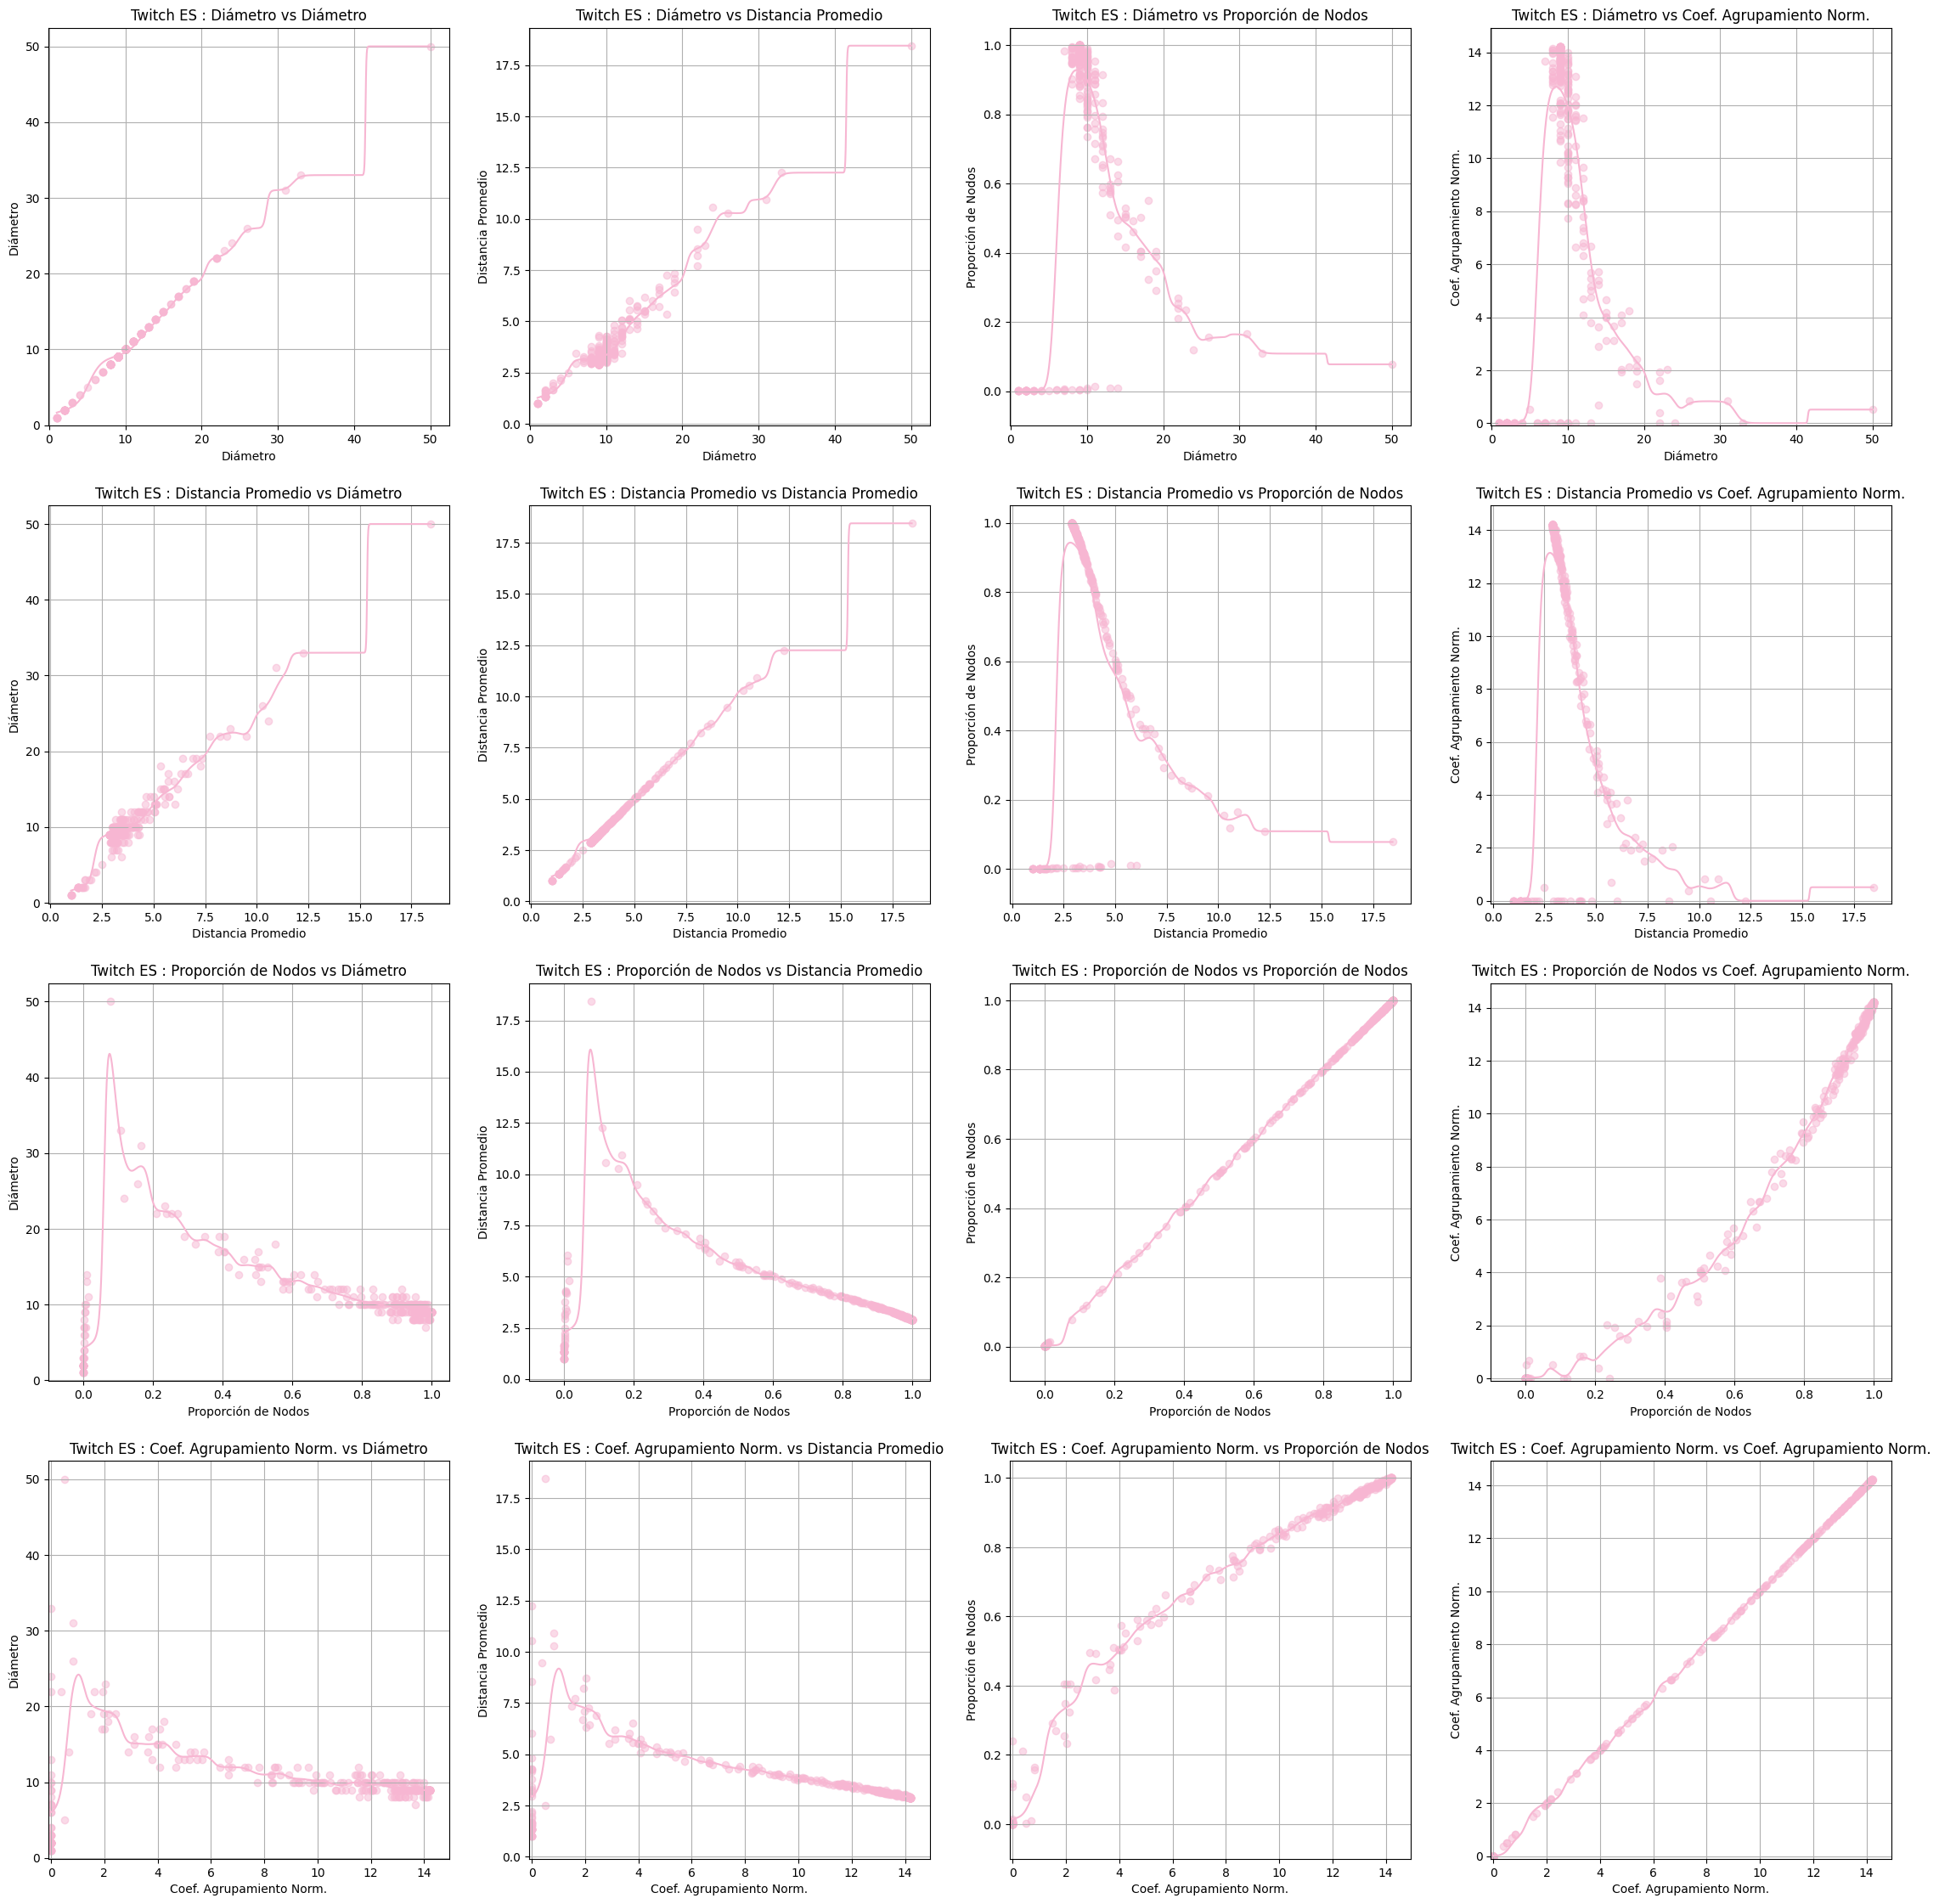

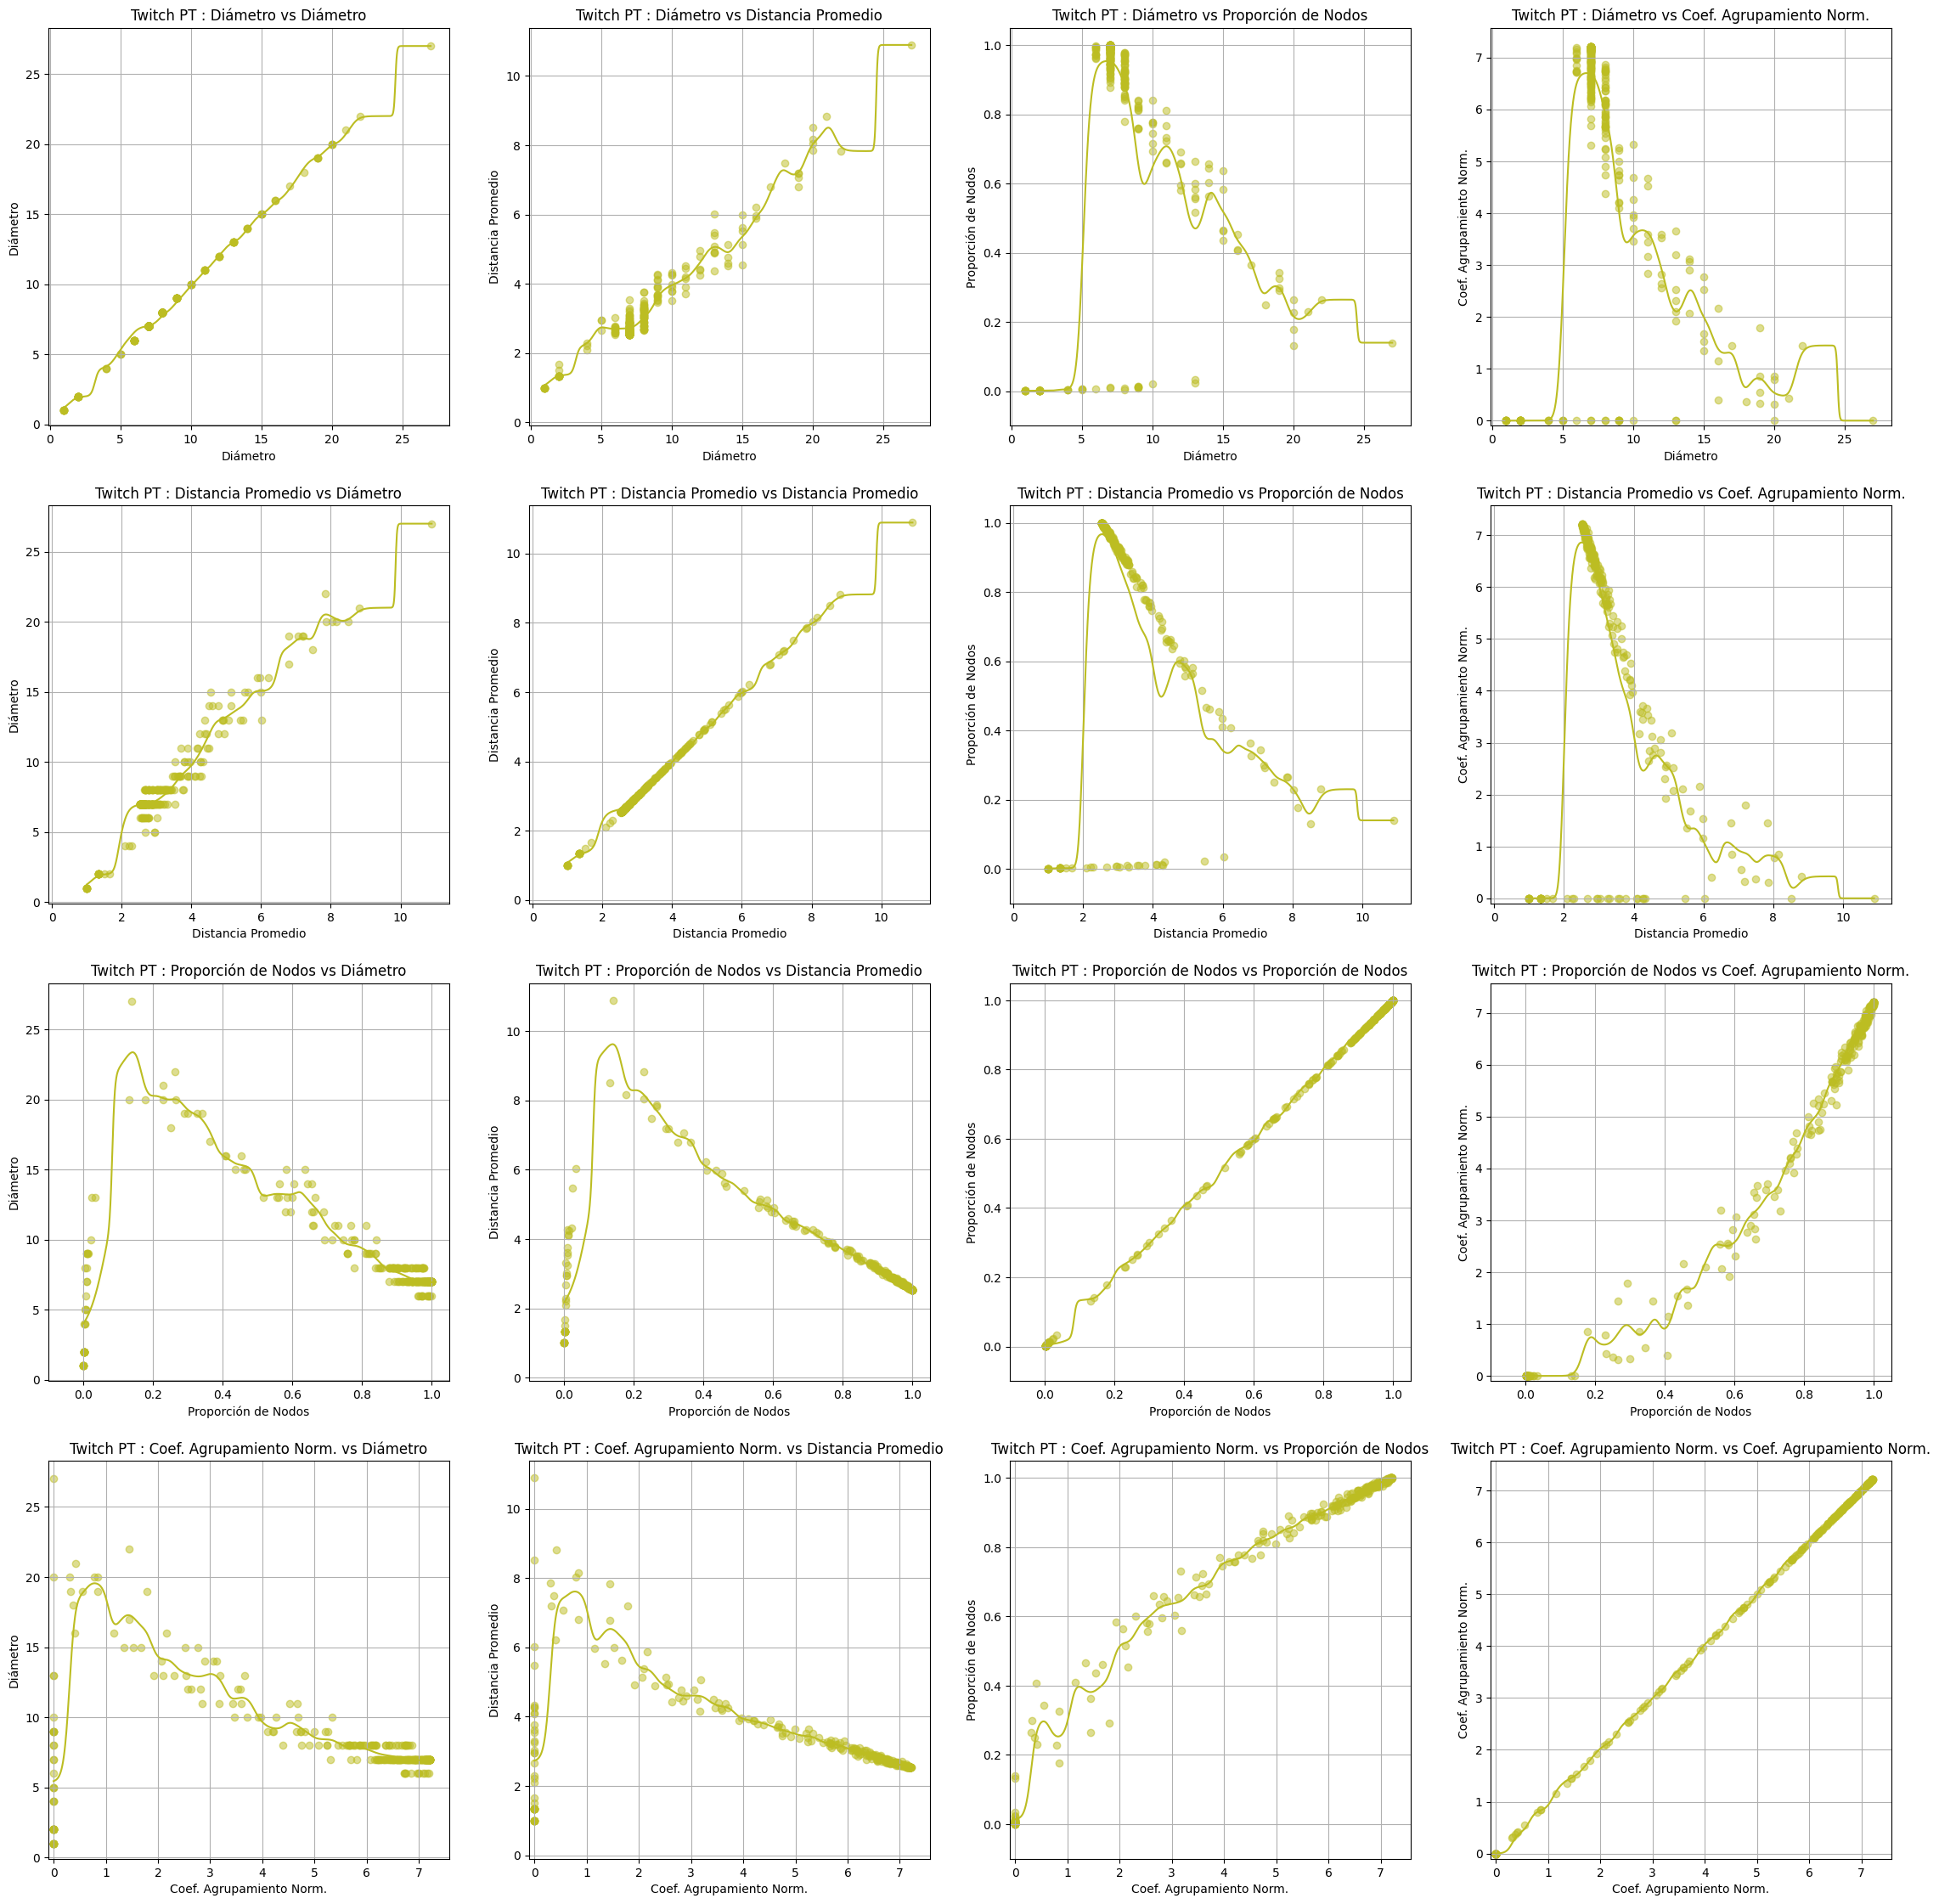

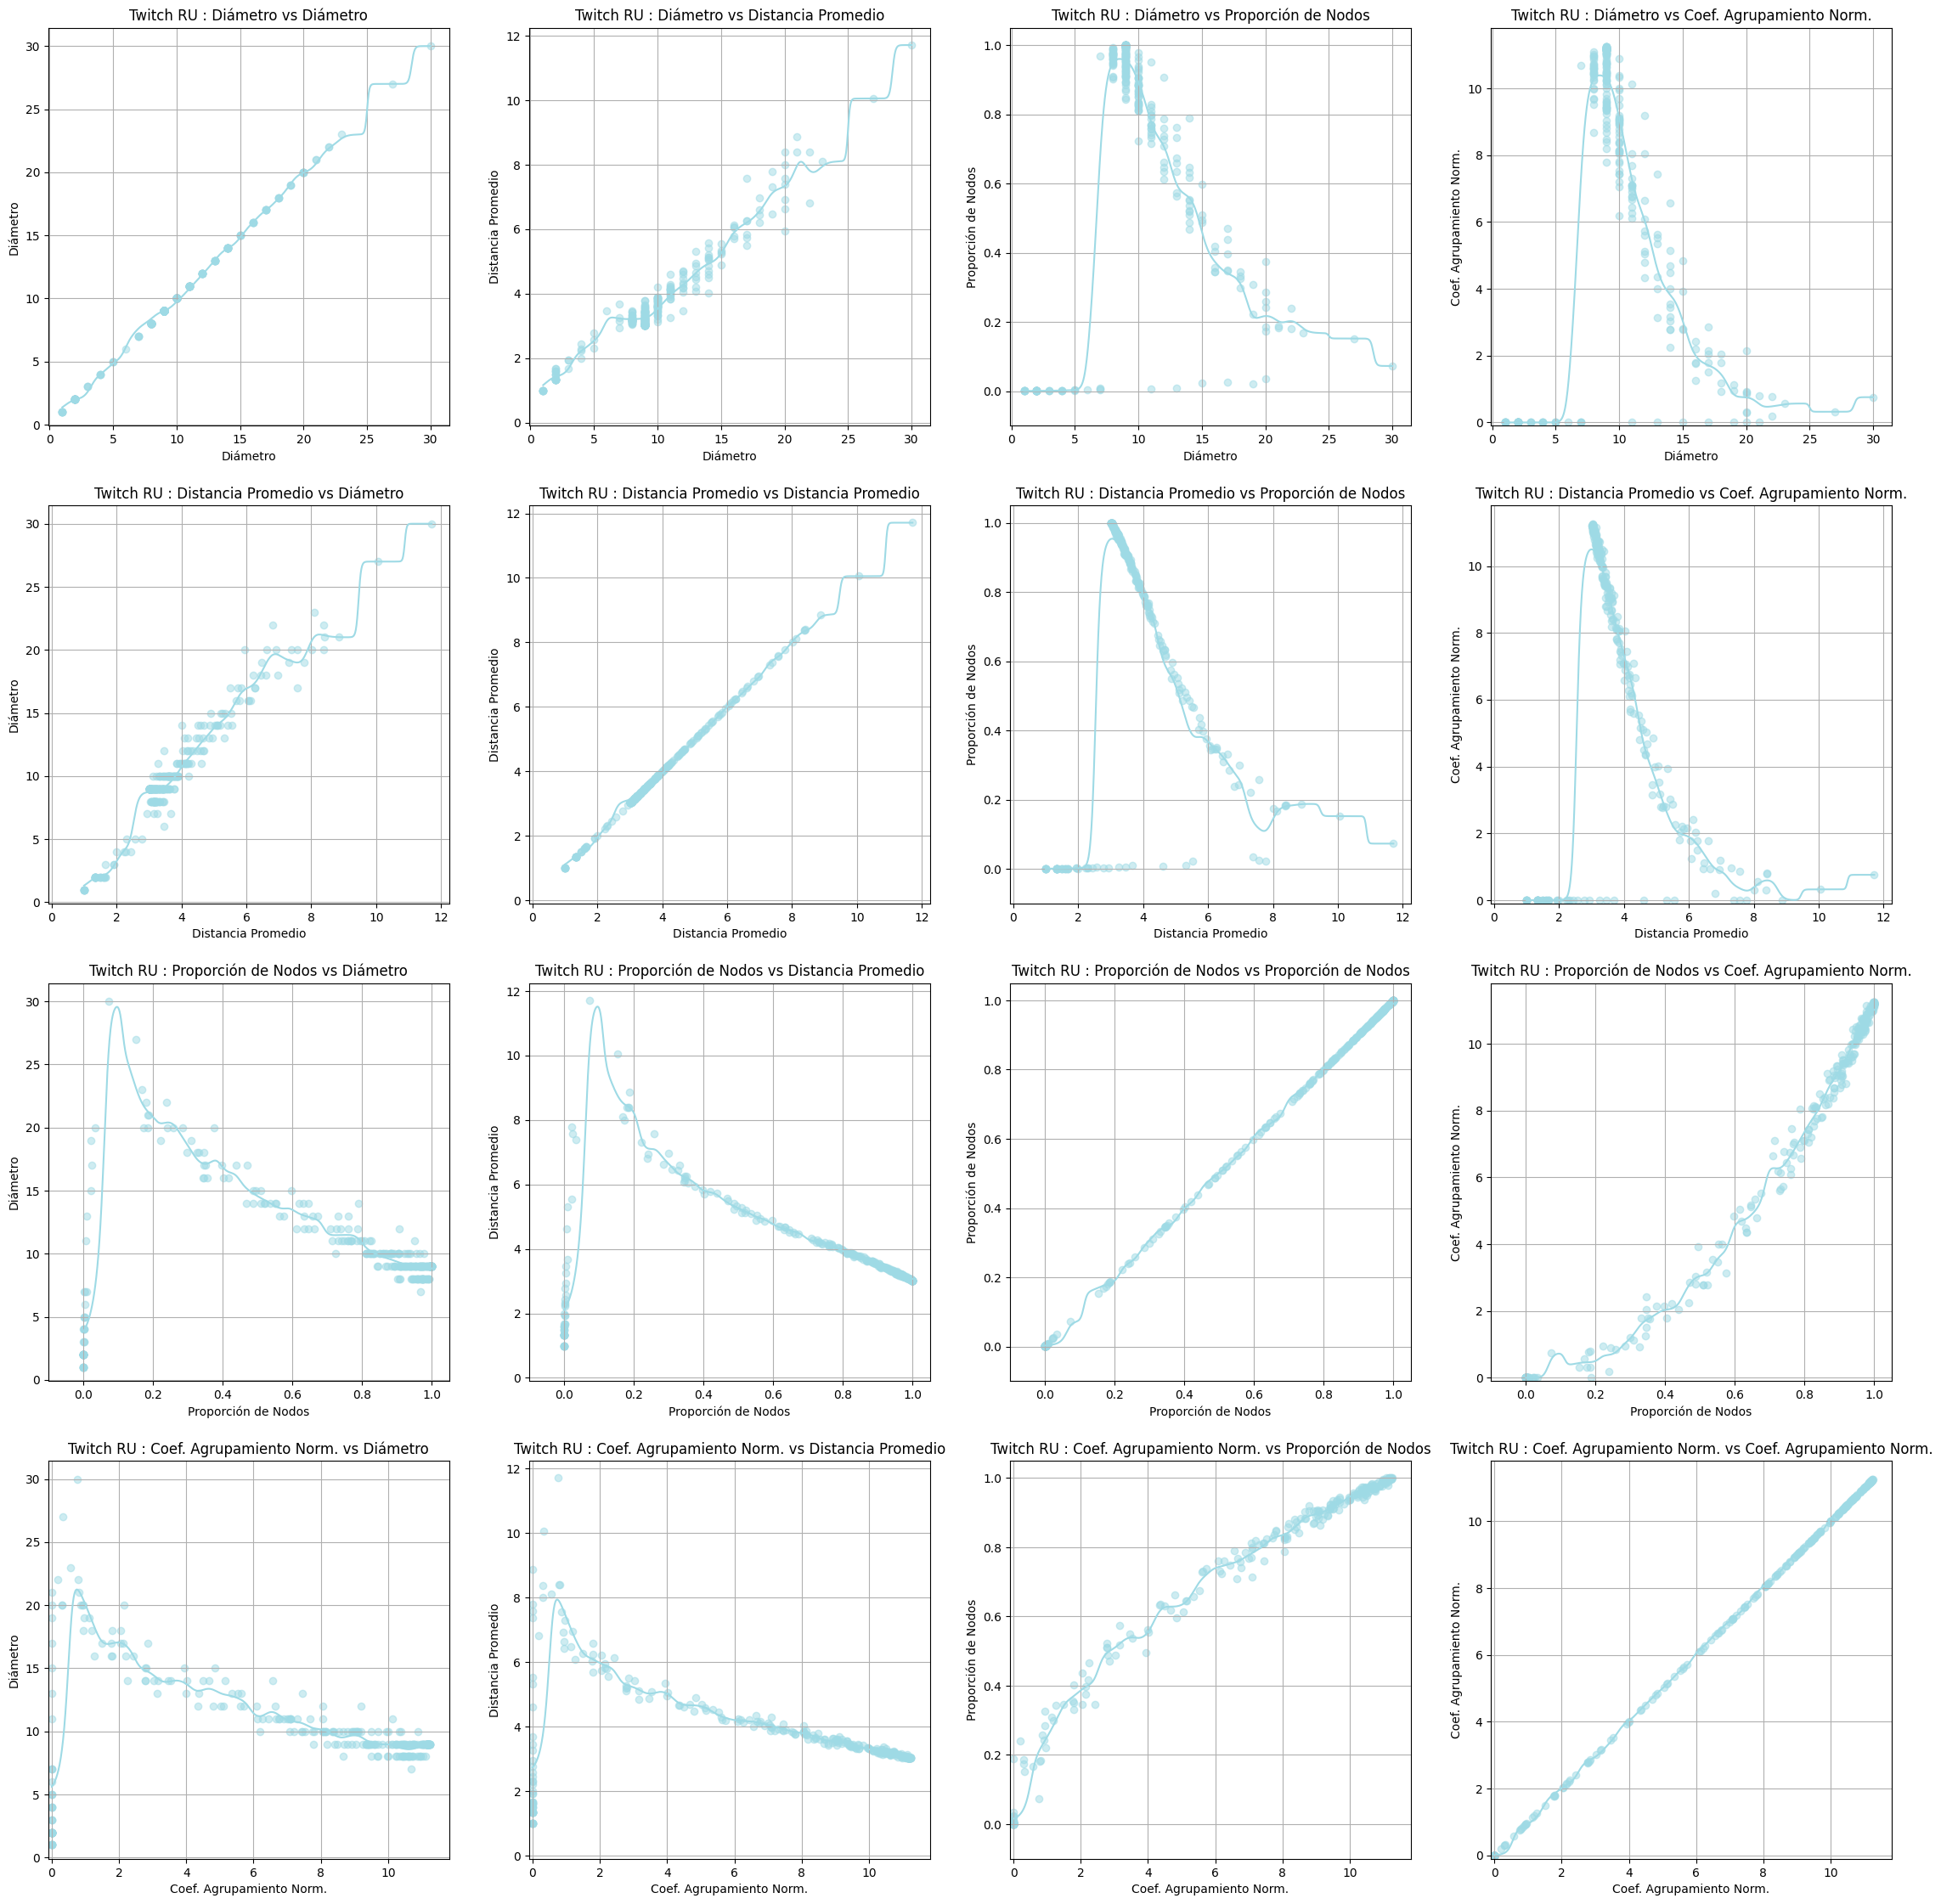

In [58]:
from itertools import product
n = len(chicos)
fig_resumen, ax_resumen = plt.subplots(4,4, figsize=(28, 28))

colores = plt.cm.get_cmap("tab20", n)

barra = tqdm(total = 4 * 4 * len(chicos))
for i, (nombre, G) in enumerate(chicos):
    fig, ax = plt.subplots(4,4, figsize=(28, 28))
    diams =  diametros[i][0][1] + diametros[i][1][1]
    dists = distancias[i][0][1] + distancias[i][1][1]
    tams = tamanios[i][0][1] + tamanios[i][1][1]
    agrupamiento = agrupamientos[i][0][1] + agrupamientos[i][1][1]
    agrupamiento = list(map(lambda x: 0 if np.isnan(x) else x, agrupamiento))

    metricas = [(diams,"Diámetro"),(dists,"Distancia Promedio"),(tams,"Proporción de Nodos"), (agrupamiento,"Coef. Agrupamiento Norm.")]
    metricas = [(np.array(metrica),nombre) for metrica, nombre in metricas]
    
    for (x,y) in product(range(4),range(4)):

        S = np.std(metricas[x][0])
        sigmas = np.linspace(0,np.max(metricas[x][0])-np.min(metricas[x][0]), 51)[1:]
        errores = []
        for sigma in sigmas:
            y_est = []
            for (it, x_i) in enumerate(metricas[x][0]):
                pesos = np.delete(np.exp(-((metricas[x][0]-x_i)**2)/(2*sigma**2)),it)
                pesos = pesos/np.sum(pesos)
                y_in = np.delete(metricas[y][0],it)
                y_est.append(np.dot(pesos, y_in))
            errores.append(np.sum((y_est - metricas[y][0])**2))
        
        x_est = np.linspace(min(metricas[x][0]), max(metricas[x][0]), 1000)
        sigma = sigmas[np.argmin(errores)]
        y_est = []
        
        for x_i in x_est:
            pesos = np.exp(-((metricas[x][0]-x_i)**2)/(2*sigma**2))
            pesos = pesos/np.sum(pesos)
            y_est.append(np.dot(pesos, metricas[y][0]))

        ax[x,y].grid()
        ax[x,y].scatter(metricas[x][0],metricas[y][0], color = colores(i), alpha=0.5)
        ax[x,y].plot(x_est, y_est, color=colores(i))
        ax_resumen[x,y].scatter(metricas[x][0],metricas[y][0], label=nombre, color=colores(i), alpha=0.2)
        ax_resumen[x,y].plot(x_est, y_est, color=colores(i))
        
        ax[x,y].set_xlabel(metricas[x][1])
        ax[x,y].set_ylabel(metricas[y][1])
        ax[x,y].set_title(f"{nombre} : {metricas[x][1]} vs {metricas[y][1]}")
        ax[x,y].set_xlim(-0.1, None)
        ax[x,y].set_ylim(-0.1, None)
        barra.update(1)
    fig.show()

for k in product(range(4),range(4)):
    (x,y) = k
    ax_resumen[k].set_xlabel(metricas[x][1])
    ax_resumen[k].set_ylabel(metricas[y][1])
    ax_resumen[k].legend()
    ax_resumen[k].grid()
    ax_resumen[k].set_title(f"Todos los datasets:\n {metricas[x][1]} vs {metricas[y][1]}", fontsize=12, fontweight="bold")
    ax_resumen[k].set_xlim(-0.1, None)
    ax_resumen[k].set_ylim(-0.1, None)

fig_resumen.show()
plt.plot()
clear_output()

En las gráficas anteriores la línea de aproximación se calculó con un ajuste no paramétrico utilizando un kernel normal, la varianza del mismo se calculó mediante validación cruzada sobre una grilla de valores.

Respecto de las baterías de gráficos de arriba, es notable como en los distintos grafos las curvas generadas son similares.


También resalta como **Coautor CS** tiene un coeficiente de agrupamiento normalizado en una escala completamente distinta a los demás grafos.


Se ve que en general, como cabría esperar, las características de Small World se correlacionan bien (al menos viendo los gráficos). Es decir, tienen a coincidir:


* Valor bajos (altos) del diámetro.
* Valor bajos (altos) de la distancia promedio.
* Valores altos (bajos) del coeficiente de agrupamiento normalizado.
* Valor altos (bajos) del tamaño de la componente conexa más grande.


Esto es consistente con pensar que son métricas que reflejan un mismo fenómeno, en este caso la propiedad de mundo pequeño.


*En lo anterior se ha ignorado el dataset de Karate, ya que aunque las observaciones le aplican parcialmente, al ser un grafo tan chico hay mucho más ruido en las observaciones.*



# Conclusiones

Lo que se desprende del presente estudio no es solo una verificación empirica del hecho de que los grafos sociales tienen la propiedad de mundo pequeño, sino además que esta propiedad es robusta al retirar una cantidad moderada de aristas.

Al retirar la mitad de las aristas ni el diámetro ni la distancia promedio aumentan significativamente y la componente más grande conserva más del 80% de los nodos totales. 

Esto tiene sentido si se tiene en cuenta que son grafos donde la cantidad de aristas es significativamente mayor a la cantidad de nodos, por lo cual hay mucha redundancia, lo que explica su resistencia a la pérdida de aristas. Aunque no sea una cantidad cuadrática de aristas, alcanza para que al reducir en una proporción fija la cantidad de aristas, la mayor componente conexa mantenga a una amplia mayoría de los nodos.

Estas dos cosas pueden explicarse también al tener en cuenta la semántica de las aristas. Como estas modelan interacciones sociales, es esperable que no se den de forma aislada, sino que, generalmente, como parte de un grupo de aristas que vinculan fuertemente a un grupo de nodos entre sí. 

